In [3]:
import sys
sys.path.append("../..") # Adds higher directory to python modules path.

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from models.Loader import load_model
from utils.shap_tools import ChronoSHAP
from models.Wrappers import Transformer_wrapper, Reduced_transformer_wrapper, Reduced_io_transformer_wrapper, Reduced_o_DLinear_wrapper
from torch.autograd import Variable
from cycler import cycler

# import argparse
import os
import torch
# import copy
# from exp.exp_main import Exp_Main
# import random
import numpy as np

import shap
import pickle
import warnings

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


%matplotlib qt5 
# %matplotlib ipympl
%matplotlib inline

warnings.filterwarnings('ignore', message='.*unrecognized nn.Module: LayerNorm.*')


In [2]:
import pandas as pd 

data_path = "dataset/"
datasets = dict()

# data_files = os.listdir(data_path)
# data_files.remove("all_six_datasets.zip")
# print(len(data_files))

# for f in ["electricity.csv", "ETTh1.csv", "ETTh2.csv", "ETTm1.csv", "ETTm2.csv", "exchange_rate.csv", "national_illness.csv", "traffic.csv", "weather.csv"]:
for f in ["exchange_rate.csv"]:
    print(f.replace(".csv",""))        
    dataset = pd.read_csv(data_path+f)
#     display(dataset.describe())
    datasets[f.replace(".csv","")] = dataset

exchange_rate


date     object
0       float64
1       float64
2       float64
3       float64
4       float64
5       float64
6       float64
OT      float64
dtype: object


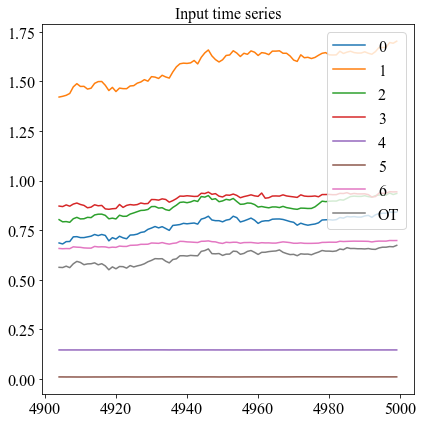

(7588, 9)


In [26]:
# %matplotlib qt5
dataset_key = "exchange_rate"

dset = datasets[dataset_key]
print(dset.dtypes)

# %matplotlib inline 
datasets["exchange_rate"][5000-96:5096-96].plot(subplots=False, figsize=(6, 6), fontsize=16).legend(fontsize=16, loc="upper right")
plt.title("Input time series", fontsize=16)
plt.tight_layout()
plt.show()
print(datasets["exchange_rate"].shape)

# dset = datasets["exchange_rate"].loc[:, datasets["exchange_rate"].columns != 'date']

Arg use_gpu initial: True
Args in experiment:
Namespace(activation='gelu', batch_size=32, c_out=8, checkpoints='F:\\Transformers old results\\checkpoints', d_ff=2048, d_layers=1, d_model=512, data='custom', data_path='exchange_rate.csv', dec_in=8, des='Exp', devices='0,1,2,3', distil=True, do_predict=False, dropout=0.05, e_layers=2, embed='timeF', embed_type=0, enc_in=8, factor=3, features='M', freq='h', gpu=0, individual=False, is_training=1, itr=1, label_len=48, learning_rate=0.0001, loss='mse', lradj='type1', model='Transformer', model_id='exchange_96', moving_avg=25, n_heads=8, num_workers=0, output_attention=False, patience=3, pred_len=96, root_path='./dataset/', save_pred_values=False, seed=10458, seq_len=96, target='OT', test_flop=False, train_epochs=10, train_only=False, use_amp=False, use_gpu=True, use_multi_gpu=False)
Use GPU: cuda:0
F:\Transformers old results\checkpoints/exchange_96_Transformer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0_seed

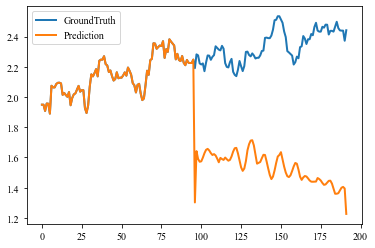

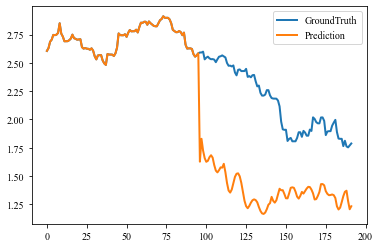

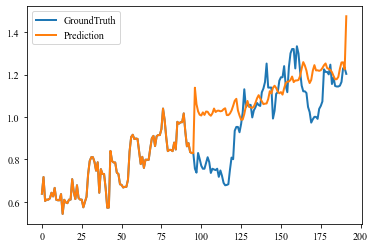

In [4]:
#       "--checkpoints", "F:\Transformers old results\checkpoints",
#       "--seed", "10458", \

model_args = [
    "--is_training", "1", \
    "--seed", "10458", \
    "--num_workers", "0", \
    "--root_path", "./dataset/", \
    "--data_path", "exchange_rate.csv", \
    "--model_id", "exchange_96", \
    "--model", "Transformer", \
    "--data", "custom", \
    "--features", "M", \
    "--seq_len", "96", \
    "--label_len", "48", \
    "--pred_len", "96", \
    "--e_layers", "2", \
    "--d_layers", "1", \
    "--factor", "3", \
    "--enc_in", "8", \
    "--dec_in", "8", \
    "--c_out", "8", \
    "--des", 'Exp', \
    "--itr", "1", \
    "--checkpoints", "F:\Transformers old results\checkpoints"]

exp, model, setting = load_model(model_args, load=True, return_copy=False)
# exp_no_train, model_no_train, setting_no_train = load_model(model_args, load=False, return_copy=False)

model.eval()
# model_no_train.eval()

# print("Testing trained model")
exp.test(setting)
# print("Testing untrained model")
# exp_no_train.test(setting_no_train)

# display(model)

In [153]:
model

Model(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(8, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(8, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
          

In [7]:
data, loader = exp._get_data("test")
print("test data type",type(data))
print("test loader type",type(loader))

print("test data_x shape",data.data_x.shape)
print("test data_y shape",data.data_y.shape)
print("test data_stamp shape",data.data_stamp.shape)

display(data.data_x[0:5,0:5])
display(data.data_y[0:5,0:5])

test 1422
test data type data_provider.data_loader.Dataset_Custom
test loader type torch.utils.data.dataloader.DataLoader
test data_x shape (1613, 8)
test data_y shape (1613, 8)
test data_stamp shape (1613, 4)


array([[ 2.74921602, -0.67234377,  1.84301689,  2.78282589,  0.78109494],
       [ 2.75157278, -0.67234377,  1.84301689,  2.78282589,  0.78109494],
       [ 2.67890114, -0.68885139,  1.79601561,  2.72405395,  0.78052119],
       [ 2.74293132, -0.64674682,  1.83565664,  2.71577002,  0.7825102 ],
       [ 2.75363858, -0.68567042,  1.82922366,  2.69821688,  0.78744449]])

array([[ 2.74921602, -0.67234377,  1.84301689,  2.78282589,  0.78109494],
       [ 2.75157278, -0.67234377,  1.84301689,  2.78282589,  0.78109494],
       [ 2.67890114, -0.68885139,  1.79601561,  2.72405395,  0.78052119],
       [ 2.74293132, -0.64674682,  1.83565664,  2.71577002,  0.7825102 ],
       [ 2.75363858, -0.68567042,  1.82922366,  2.69821688,  0.78744449]])

In [8]:
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(loader):
    if i<1:
        print("Shapes of batch_x: {}, batch_y: {}".format(batch_x.shape, batch_y.shape, batch_x_mark.shape, batch_y_mark.shape))
        print("batch_x: ",batch_x[0,:,0])
        print("batch_y: ",batch_y[0,:,0])
        print()
#     elif i>41:
#         print("Shapes of batch_x: {}, batch_y: {}, batch_x_mark: {}, batch_y_mark: {}".format(batch_x.shape, batch_y.shape, batch_x_mark.shape, batch_y_mark.shape))
#         print("batch_x: ",batch_x[0,48:55,0])
#         print("batch_y: ",batch_y[0,0:7,0])
#         print()        
        
print()
print("Shapes of batch_x: {}, batch_y: {}, batch_x_mark: {}, batch_y_mark: {}".format(batch_x.shape, batch_y.shape, batch_x_mark.shape, batch_y_mark.shape))

Shapes of batch_x: torch.Size([32, 96, 8]), batch_y: torch.Size([32, 144, 8])
batch_x:  tensor([2.7492, 2.7516, 2.6789, 2.7429, 2.7536, 2.6934, 2.9222, 2.9189, 2.9213,
        2.9228, 2.9621, 2.9577, 2.9726, 2.8730, 2.8917, 2.8786, 2.8929, 2.9388,
        2.8185, 2.9057, 2.9161, 2.9795, 3.0327, 3.0922, 3.0434, 3.0556, 3.0552,
        2.9460, 2.9076, 2.9956, 3.0677, 3.1401, 3.1618, 3.1899, 3.1966, 3.1232,
        3.2220, 3.2380, 3.2380, 3.2462, 3.2317, 3.2354, 3.2395, 3.2338, 3.1805,
        3.1696, 3.1725, 3.1889, 3.0998, 3.0964, 3.0964, 3.1226, 3.1589, 3.1105,
        3.1197, 3.0928, 3.0577, 3.0513, 3.0420, 2.9688, 3.0047, 3.0023, 2.9307,
        2.9022, 2.8671, 2.9737, 3.0677, 3.0270, 3.1191, 3.1308, 3.2051, 3.2312,
        3.1356, 3.1183, 3.1505, 3.0901, 3.1377, 3.0853, 3.0937, 3.0368, 3.1279,
        3.0619, 3.0513, 2.9465, 2.8921, 2.9481, 2.8768, 2.8598, 2.8934, 2.8757,
        2.9065, 2.9547, 2.9039, 2.9140, 2.9156, 2.9330], dtype=torch.float64)
batch_y:  tensor([3.0998, 3.0964, 

In [9]:
pred_data, pred_loader = exp._get_data("pred")

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(pred_loader):
    print("Shapes of batch_x: {}, batch_y: {}".format(batch_x.shape, batch_y.shape, batch_x_mark.shape, batch_y_mark.shape))
    print("batch_x: ",batch_x[0,:,0])
    print("batch_y: ",batch_y[0,:,0])
    print()

pred 1
Shapes of batch_x: torch.Size([1, 96, 8]), batch_y: torch.Size([1, 48, 8])
batch_x:  tensor([-0.0761, -0.0727, -0.0965, -0.0761, -0.0806, -0.0808, -0.0767, -0.1143,
        -0.1086, -0.1403, -0.1468, -0.1361, -0.1186, -0.1719, -0.1468, -0.1433,
        -0.1041, -0.1118, -0.1116, -0.1061, -0.0711, -0.0343, -0.1007, -0.1243,
        -0.1201, -0.1201, -0.1245, -0.0885, -0.0858, -0.1300, -0.1332, -0.1256,
        -0.1327, -0.1218, -0.0937, -0.0694, -0.0690, -0.0677, -0.0703, -0.0684,
        -0.0521, -0.0284, -0.0709, -0.1277, -0.1587, -0.1585, -0.1585, -0.1671,
        -0.1700, -0.2051, -0.2288, -0.3132, -0.3132, -0.3158, -0.3033, -0.2786,
        -0.2802, -0.2606, -0.2509, -0.2376, -0.2434, -0.2133, -0.2235, -0.2804,
        -0.2624, -0.2374, -0.2282, -0.2337, -0.2143, -0.2296, -0.2144, -0.2370,
        -0.2402, -0.2327, -0.2341, -0.2051, -0.1998, -0.1853, -0.3146, -0.3397,
        -0.3459, -0.3459, -0.3692, -0.3800, -0.3841, -0.4057, -0.4345, -0.4235,
        -0.4235, -0.4190, -0

test 1422
test data shape x;y: (1613, 8) ; (1613, 8)
Shapes of batch_x: torch.Size([32, 96, 8]), batch_y: torch.Size([32, 144, 8]), batch_x_mark: torch.Size([32, 96, 4]), batch_y_mark: torch.Size([32, 144, 4])
dec_inp shapes: torch.Size([32, 144, 8])
In else (no output_attention), direct outputs shape: torch.Size([32, 96, 8])
f_dim: 0
outputs and batch_y shapes: (32, 96, 8) ; (32, 96, 8)

Shapes of batch_x: torch.Size([32, 96, 8]), batch_y: torch.Size([32, 144, 8]), batch_x_mark: torch.Size([32, 96, 4]), batch_y_mark: torch.Size([32, 144, 4])
dec_inp shapes: torch.Size([32, 144, 8])
In else (no output_attention), direct outputs shape: torch.Size([32, 96, 8])
f_dim: 0
outputs and batch_y shapes: (32, 96, 8) ; (32, 96, 8)

Shapes of batch_x: torch.Size([32, 96, 8]), batch_y: torch.Size([32, 144, 8]), batch_x_mark: torch.Size([32, 96, 4]), batch_y_mark: torch.Size([32, 144, 4])
dec_inp shapes: torch.Size([32, 144, 8])
In else (no output_attention), direct outputs shape: torch.Size([32, 96


Shapes of batch_x: torch.Size([32, 96, 8]), batch_y: torch.Size([32, 144, 8]), batch_x_mark: torch.Size([32, 96, 4]), batch_y_mark: torch.Size([32, 144, 4])
dec_inp shapes: torch.Size([32, 144, 8])
In else (no output_attention), direct outputs shape: torch.Size([32, 96, 8])
f_dim: 0
outputs and batch_y shapes: (32, 96, 8) ; (32, 96, 8)

Shapes of batch_x: torch.Size([32, 96, 8]), batch_y: torch.Size([32, 144, 8]), batch_x_mark: torch.Size([32, 96, 4]), batch_y_mark: torch.Size([32, 144, 4])
dec_inp shapes: torch.Size([32, 144, 8])
In else (no output_attention), direct outputs shape: torch.Size([32, 96, 8])
f_dim: 0
outputs and batch_y shapes: (32, 96, 8) ; (32, 96, 8)

Shapes of batch_x: torch.Size([32, 96, 8]), batch_y: torch.Size([32, 144, 8]), batch_x_mark: torch.Size([32, 96, 4]), batch_y_mark: torch.Size([32, 144, 4])
dec_inp shapes: torch.Size([32, 144, 8])
In else (no output_attention), direct outputs shape: torch.Size([32, 96, 8])
f_dim: 0
outputs and batch_y shapes: (32, 96, 

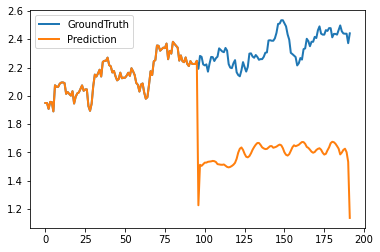

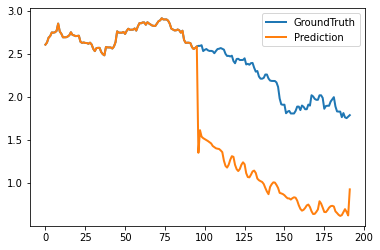

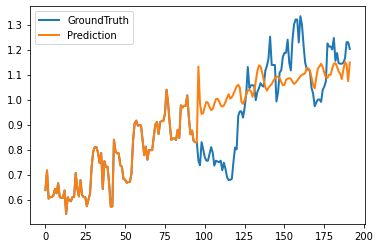

In [13]:
exp.test(setting)


In [14]:
print(data.data_y.shape)
# print(data.cols)
preds = exp.predict_simple(setting)
print(preds.shape)

(1613, 8)
pred 1
dec_inp shapes: torch.Size([1, 144, 8])
(1, 96, 8)


# Prepare inputs of the model

In [5]:
train_data, train_loader = exp._get_data("train")
for i, (batch_x_train_b, batch_y_train_b, batch_x_mark_train_b, batch_y_mark_train_b) in enumerate(train_loader):
#     print("i={}, Shapes of batch_x: {}, batch_x_mark: {}, batch_y: {}, batch_y_mark: {}".format(i, batch_x_train_b.shape, batch_x_mark_train_b.shape, batch_y_train_b.shape, batch_y_mark_train_b.shape))
    if (i==0):
        batch_x_train = torch.cat((batch_x_train_b,))
        batch_y_train = torch.cat((batch_y_train_b,))
        batch_x_mark_train = torch.cat((batch_x_mark_train_b,))
        batch_y_mark_train = torch.cat((batch_y_mark_train_b,))
    else:
        batch_x_train = torch.cat((batch_x_train, batch_x_train_b))
        batch_y_train = torch.cat((batch_y_train, batch_y_train_b))
        batch_x_mark_train = torch.cat((batch_x_mark_train, batch_x_mark_train_b))
        batch_y_mark_train = torch.cat((batch_y_mark_train, batch_y_mark_train_b))

batch_x_train = batch_x_train.float().to(next(model.parameters()).device)
batch_y_train = batch_y_train.float().to(next(model.parameters()).device)
batch_x_mark_train = batch_x_mark_train.float().to(next(model.parameters()).device)
batch_y_mark_train = batch_y_mark_train.float().to(next(model.parameters()).device)

# dec_inp_train = torch.zeros_like(batch_y_train[:, -train_data.pred_len:, :]).float()
# dec_inp_train = torch.cat([batch_y_train[:, :train_data.label_len, :], dec_inp_train], dim=1).float().to(next(model.parameters()).device)

dec_inp_train = torch.zeros([batch_y_train.shape[0], train_data.pred_len, batch_y_train.shape[2]]).float().to(batch_y_train.device)
dec_inp_train = torch.cat([batch_y_train[:, :train_data.label_len, :], dec_inp_train], dim=1).float().to(next(model.parameters()).device)

print("Model input shapes: batch_x: {}, batch_x_mark: {}, dec_inp: {}, batch_y_mark: {}".format(batch_x_train.shape, batch_x_mark_train.shape, dec_inp_train.shape, batch_y_mark_train.shape))

train 5120
Model input shapes: batch_x: torch.Size([5120, 96, 8]), batch_x_mark: torch.Size([5120, 96, 4]), dec_inp: torch.Size([5120, 144, 8]), batch_y_mark: torch.Size([5120, 144, 4])


In [37]:
batch_y_mark_train.shape

torch.Size([5120, 144, 4])

In [42]:
model

Model(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(8, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(8, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
          

In [41]:
batch_x_mark_train[:,:,1]

tensor([[-0.1667,  0.0000,  0.1667,  ...,  0.1667,  0.3333,  0.5000],
        [ 0.0000,  0.1667,  0.3333,  ...,  0.3333,  0.5000, -0.5000],
        [ 0.3333,  0.5000, -0.5000,  ..., -0.5000, -0.3333, -0.1667],
        ...,
        [ 0.5000, -0.5000, -0.3333,  ..., -0.3333, -0.1667,  0.0000],
        [-0.3333, -0.1667,  0.0000,  ...,  0.0000,  0.1667,  0.3333],
        [ 0.3333,  0.5000, -0.5000,  ..., -0.5000, -0.3333, -0.1667]],
       device='cuda:0')

In [40]:
batch_y_mark_train[:,:,1]

tensor([[-0.3333, -0.1667,  0.0000,  ..., -0.1667,  0.0000,  0.1667],
        [-0.1667,  0.0000,  0.1667,  ...,  0.0000,  0.1667,  0.3333],
        [ 0.1667,  0.3333,  0.5000,  ...,  0.3333,  0.5000, -0.5000],
        ...,
        [ 0.3333,  0.5000, -0.5000,  ...,  0.5000, -0.5000, -0.3333],
        [-0.5000, -0.3333, -0.1667,  ..., -0.3333, -0.1667,  0.0000],
        [ 0.1667,  0.3333,  0.5000,  ...,  0.3333,  0.5000, -0.5000]],
       device='cuda:0')

In [36]:
dec_inp_train_alt = torch.zeros([batch_y_train.shape[0], train_data.pred_len, batch_y_train.shape[2]]).float().to(batch_y_train.device)
print(dec_inp_train_alt.shape)

dec_inp_train_alt = torch.cat([batch_y_train[:, :train_data.label_len, :], dec_inp_train_alt], dim=1).float().to(next(model.parameters()).device)
print(dec_inp_train_alt.shape)

print("Results different? \t", bool(np.count_nonzero(dec_inp_train[:,:,:].cpu()-dec_inp_train_alt[:,:,:].cpu())))

torch.Size([32, 96, 8])
torch.Size([32, 144, 8])
Results different? 	 False


In [55]:
pred_data, pred_loader = exp._get_data("pred")

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(pred_loader):
    print("Shapes of batch_x: {}, batch_x_mark: {}, batch_y: {}, batch_y_mark: {}".format(batch_x.shape, batch_x_mark.shape, batch_y.shape, batch_y_mark.shape))
#     print("batch_x: ",batch_x[0,:,0])
#     print("batch_y: ",batch_y[0,:,0])
    print()

batch_x = batch_x.float().to(next(model.parameters()).device)
batch_y = batch_y.float().to(next(model.parameters()).device)
batch_x_mark = batch_x_mark.float().to(next(model.parameters()).device)
batch_y_mark = batch_y_mark.float().to(next(model.parameters()).device)

dec_inp = torch.zeros([batch_y.shape[0], pred_data.pred_len, batch_y.shape[2]]).float().to(batch_y.device)
dec_inp = torch.cat([batch_y[:, :pred_data.label_len, :], dec_inp], dim=1).float().to(next(model.parameters()).device)

print("Model input shapes: batch_x: {}, batch_x_mark: {}, dec_inp: {}, batch_y_mark: {}".format(batch_x.shape, batch_x_mark.shape, dec_inp.shape, batch_y_mark.shape))

pred 1
Shapes of batch_x: torch.Size([1, 96, 8]), batch_x_mark: torch.Size([1, 96, 4]), batch_y: torch.Size([1, 48, 8]), batch_y_mark: torch.Size([1, 144, 4])

Model input shapes: batch_x: torch.Size([1, 96, 8]), batch_x_mark: torch.Size([1, 96, 4]), dec_inp: torch.Size([1, 144, 8]), batch_y_mark: torch.Size([1, 144, 4])


In [6]:
print("pred_data type", pred_data.data_x[0,4].dtype)
print("pred_data value", pred_data.data_x[0,4])

print("batch_x type", batch_x.type())
print("batch_x value", batch_x[:,0,4].item())

display(next(model.parameters()).device)

pred_data type float64
pred_data value 0.2961983023728179
batch_x type torch.cuda.FloatTensor
batch_x value 0.296198308467865


device(type='cuda', index=0)

In [13]:
print("batch_x shape: \t\t", batch_x.shape)
print("batch_x_mark shape: \t", batch_x_mark.shape)
print("batch_y shape: \t\t", batch_y.shape)
print("batch_y_mark shape: \t", batch_y_mark.shape)
print("dec_inp shape: \t\t", dec_inp.shape)

print("device: \t\t", batch_x.device)

preds = exp.predict_simple(setting)
print("preds shape: \t\t", preds[:,::,:].shape)
print("preds type: \t\t", type(preds))

model.eval()
raw_preds = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
raw_preds = pred_data.inverse_transform(raw_preds.cpu().detach().numpy())
print("raw_preds shape: \t", raw_preds[:,::,:].shape)
print("raw_preds type: \t", type(raw_preds))

# Check if both ways of predicting give the same results

print("Results different? \t", bool(np.count_nonzero(preds[:,:,:]-raw_preds[:,:,:])))

batch_x shape: 		 torch.Size([1, 96, 8])
batch_x_mark shape: 	 torch.Size([1, 96, 4])
batch_y shape: 		 torch.Size([1, 48, 8])
batch_y_mark shape: 	 torch.Size([1, 144, 4])
dec_inp shape: 		 torch.Size([1, 144, 8])
device: 		 cuda:0
pred 1
preds shape: 		 (1, 96, 8)
preds type: 		 <class 'numpy.ndarray'>
raw_preds shape: 	 (1, 96, 8)
raw_preds type: 	 <class 'numpy.ndarray'>
Results different? 	 False


In [14]:
print("batch_x: \t\t",batch_x.shape)
print("batch_x_mark: \t\t",batch_x_mark.shape)
print("batch_y: \t\t",batch_y.shape)
print("dec_inp: \t\t",dec_inp.shape)
print("batch_y_mark: \t\t",batch_y_mark.shape)

# print(batch_x_mark[:,48:,:])
# print(batch_y_mark[:,:48,:])

# print(batch_x_mark[:,48:,:]-batch_y_mark[:,:48,:])

print("Values different? \t", bool(torch.count_nonzero(batch_x_mark[:,48:,:]-batch_y_mark[:,:48,:])))

batch_x: 		 torch.Size([1, 96, 8])
batch_x_mark: 		 torch.Size([1, 96, 4])
batch_y: 		 torch.Size([1, 48, 8])
dec_inp: 		 torch.Size([1, 144, 8])
batch_y_mark: 		 torch.Size([1, 144, 4])
Values different? 	 False


In [128]:
print("batch_x: \t\t",batch_x.shape)
print("batch_x_mark: \t\t",batch_x_mark.shape)
print("dec_inp: \t\t",dec_inp.shape)
print("batch_y_mark: \t\t",batch_y_mark.shape)

print("\n\tflattening\n")

flat_batch_x = batch_x.flatten()
flat_batch_x_mark = batch_x_mark.flatten()
flat_dec_inp = dec_inp.flatten()
flat_batch_y_mark = batch_y_mark.flatten()

print("flat_batch_x: \t\t",flat_batch_x.shape)
print("flat_batch_x_mark: \t",flat_batch_x_mark.shape)
print("flat_dec_inp: \t\t",flat_dec_inp.shape)
print("flat_batch_y_mark: \t",flat_batch_y_mark.shape)

# new_input.unflatten(0,batch_x.shape)

new_input = torch.cat((flat_batch_x, flat_batch_x_mark, flat_dec_inp, flat_batch_y_mark))

print("new_input: \t\t",new_input.shape)

batch_x: 		 torch.Size([1, 96, 8])
batch_x_mark: 		 torch.Size([1, 96, 4])
dec_inp: 		 torch.Size([1, 144, 8])
batch_y_mark: 		 torch.Size([1, 144, 4])

	flattening

flat_batch_x: 		 torch.Size([768])
flat_batch_x_mark: 	 torch.Size([384])
flat_dec_inp: 		 torch.Size([1152])
flat_batch_y_mark: 	 torch.Size([576])
new_input: 		 torch.Size([2880])


In [136]:
train_data, train_loader = exp._get_data("train")
for i, (batch_x_train, batch_y_train, batch_x_mark_train, batch_y_mark_train) in enumerate(train_loader):
    print("Shapes of batch_x: {}, batch_x_mark: {}, batch_y: {}, batch_y_mark: {}".format(batch_x_train.shape, batch_x_mark_train.shape, batch_y_train.shape, batch_y_mark_train.shape))
    break

batch_x_train = batch_x_train.float().to(next(model.parameters()).device)
batch_y_train = batch_y_train.float().to(next(model.parameters()).device)
batch_x_mark_train = batch_x_mark_train.float().to(next(model.parameters()).device)
batch_y_mark_train = batch_y_mark_train.float().to(next(model.parameters()).device)

dec_inp_train = torch.zeros_like(batch_y_train[:, -pred_data.pred_len:, :]).float()
dec_inp_train = torch.cat([batch_y_train[:, :pred_data.label_len, :], dec_inp_train], dim=1).float().to(next(model.parameters()).device)

print("Model input shapes: batch_x: {}, batch_x_mark: {}, dec_inp: {}, batch_y_mark: {}".format(batch_x_train.shape, batch_x_mark_train.shape, dec_inp_train.shape, batch_y_mark_train.shape))

print() 

print("batch_x_train: \t\t",batch_x_train.shape)
print("batch_x_mark_train: \t",batch_x_mark_train.shape)
print("dec_inp_train: \t\t",dec_inp_train.shape)
print("batch_y_mark_train: \t",batch_y_mark_train.shape)

print("\n\tflattening\n")

flat_batch_x_train = batch_x_train.flatten(start_dim=1)
flat_batch_x_mark_train = batch_x_mark_train.flatten(start_dim=1)
flat_dec_inp_train = dec_inp_train.flatten(start_dim=1)
flat_batch_y_mark_train = batch_y_mark_train.flatten(start_dim=1)

print("flat_batch_x_train: \t",flat_batch_x_train.shape)
print("flat_batch_x_mark_train:",flat_batch_x_mark_train.shape)
print("flat_dec_inp_train: \t",flat_dec_inp_train.shape)
print("flat_batch_y_mark_train:",flat_batch_y_mark_train.shape)

new_input_train = torch.cat((flat_batch_x_train, flat_batch_x_mark_train, flat_dec_inp_train, flat_batch_y_mark_train), dim=1)

print("new_input_train: \t",new_input_train.shape)

train 5120
Shapes of batch_x: torch.Size([32, 96, 8]), batch_x_mark: torch.Size([32, 96, 4]), batch_y: torch.Size([32, 144, 8]), batch_y_mark: torch.Size([32, 144, 4])
Model input shapes: batch_x: torch.Size([32, 96, 8]), batch_x_mark: torch.Size([32, 96, 4]), dec_inp: torch.Size([32, 144, 8]), batch_y_mark: torch.Size([32, 144, 4])

batch_x_train: 		 torch.Size([32, 96, 8])
batch_x_mark_train: 	 torch.Size([32, 96, 4])
dec_inp_train: 		 torch.Size([32, 144, 8])
batch_y_mark_train: 	 torch.Size([32, 144, 4])

	flattening

flat_batch_x_train: 	 torch.Size([32, 768])
flat_batch_x_mark_train: torch.Size([32, 384])
flat_dec_inp_train: 	 torch.Size([32, 1152])
flat_batch_y_mark_train: torch.Size([32, 576])
new_input_train: 	 torch.Size([32, 2880])


In [122]:
print("new_input: \t\t",new_input.shape)
print("\tunflattening")

unflat_batch_x, unflat_batch_x_mark, unflat_dec_inp, unflat_batch_y_mark = new_input.split([flat_batch_x.shape[-1], flat_batch_x_mark.shape[-1], flat_dec_inp.shape[-1], flat_batch_y_mark.shape[-1]])

print("unflat_batch_x: \t",unflat_batch_x.shape)
print("unflat_batch_x_mark: \t",unflat_batch_x_mark.shape)
print("unflat_dec_inp: \t",unflat_dec_inp.shape)
print("unflat_batch_y_mark: \t",unflat_batch_y_mark.shape)

print("\tunflattening")

unflat_batch_x = unflat_batch_x.unflatten(0,batch_x.shape)
unflat_batch_x_mark = unflat_batch_x_mark.unflatten(0,batch_x_mark.shape)
unflat_dec_inp = unflat_dec_inp.unflatten(0,dec_inp.shape)
unflat_batch_y_mark = unflat_batch_y_mark.unflatten(0,batch_y_mark.shape)

print("unflat_batch_x: \t",unflat_batch_x.shape)
print("unflat_batch_x_mark: \t",unflat_batch_x_mark.shape)
print("unflat_dec_inp: \t",unflat_dec_inp.shape)
print("unflat_batch_y_mark: \t",unflat_batch_y_mark.shape)

print()

print("Values different t1? \t",bool((batch_x-unflat_batch_x).count_nonzero()))
print("Values different t2? \t",bool((batch_x_mark-unflat_batch_x_mark).count_nonzero()))
print("Values different t3? \t",bool((dec_inp-unflat_dec_inp).count_nonzero()))
print("Values different t4? \t",bool((batch_y_mark-unflat_batch_y_mark).count_nonzero()))

new_input: 		 torch.Size([2880])
	unflattening
unflat_batch_x: 	 torch.Size([768])
unflat_batch_x_mark: 	 torch.Size([384])
unflat_dec_inp: 	 torch.Size([1152])
unflat_batch_y_mark: 	 torch.Size([576])
	unflattening
unflat_batch_x: 	 torch.Size([1, 96, 8])
unflat_batch_x_mark: 	 torch.Size([1, 96, 4])
unflat_dec_inp: 	 torch.Size([1, 144, 8])
unflat_batch_y_mark: 	 torch.Size([1, 144, 4])

Values different t1? 	 False
Values different t2? 	 False
Values different t3? 	 False
Values different t4? 	 False


In [137]:
print("new_input: \t\t\t",new_input_train.shape)
print("\tunflattening\n")

unflat_batch_x_train, unflat_batch_x_mark_train, unflat_dec_inp_train, unflat_batch_y_mark_train = new_input_train.split(
    [flat_batch_x_train.shape[-1], flat_batch_x_mark_train.shape[-1], 
     flat_dec_inp_train.shape[-1], flat_batch_y_mark_train.shape[-1]],dim=1)

print("unflat_batch_x_train: \t\t",unflat_batch_x_train.shape)
print("unflat_batch_x_mark_train: \t",unflat_batch_x_mark_train.shape)
print("unflat_dec_inp_train: \t\t",unflat_dec_inp_train.shape)
print("unflat_batch_y_mark_train: \t",unflat_batch_y_mark_train.shape)

print("\n\tunflattening\n")

unflat_batch_x_train = unflat_batch_x_train.unflatten(1,batch_x_train.shape[1:])
unflat_batch_x_mark_train = unflat_batch_x_mark_train.unflatten(1,batch_x_mark_train.shape[1:])
unflat_dec_inp_train = unflat_dec_inp_train.unflatten(1,dec_inp_train.shape[1:])
unflat_batch_y_mark_train = unflat_batch_y_mark_train.unflatten(1,batch_y_mark_train.shape[1:])

print("unflat_batch_x_train: \t\t",unflat_batch_x_train.shape)
print("unflat_batch_x_mark_train: \t",unflat_batch_x_mark_train.shape)
print("unflat_dec_inp_train: \t\t",unflat_dec_inp_train.shape)
print("unflat_batch_y_mark_train: \t",unflat_batch_y_mark_train.shape)

print()

print("Values different t1? \t",bool((batch_x_train-unflat_batch_x_train).count_nonzero()))
print("Values different t2? \t",bool((batch_x_mark_train-unflat_batch_x_mark_train).count_nonzero()))
print("Values different t3? \t",bool((dec_inp_train-unflat_dec_inp_train).count_nonzero()))
print("Values different t4? \t",bool((batch_y_mark_train-unflat_batch_y_mark_train).count_nonzero()))

new_input: 			 torch.Size([32, 2880])
	unflattening

unflat_batch_x_train: 		 torch.Size([32, 768])
unflat_batch_x_mark_train: 	 torch.Size([32, 384])
unflat_dec_inp_train: 		 torch.Size([32, 1152])
unflat_batch_y_mark_train: 	 torch.Size([32, 576])

	unflattening

unflat_batch_x_train: 		 torch.Size([32, 96, 8])
unflat_batch_x_mark_train: 	 torch.Size([32, 96, 4])
unflat_dec_inp_train: 		 torch.Size([32, 144, 8])
unflat_batch_y_mark_train: 	 torch.Size([32, 144, 4])

Values different t1? 	 False
Values different t2? 	 False
Values different t3? 	 False
Values different t4? 	 False


# Define wrapper

In [120]:
wrapped_model = Transformer_wrapper(exp.args).to(exp.device)

for name, param in wrapped_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

enc_embedding.value_embedding.tokenConv.weight tensor([[[-3.3246e-01, -3.2249e-02,  6.5863e-01],
         [ 4.8310e-01, -1.6484e-01, -4.5147e-01],
         [-1.1336e-01,  2.1972e-01,  1.3418e-01],
         ...,
         [ 1.2971e-01,  5.0903e-02, -2.1911e-01],
         [ 1.5865e-03, -2.9436e-02,  3.6717e-01],
         [ 4.0121e-01, -1.0108e-01, -2.9794e-01]],

        [[-6.1994e-03, -1.2083e-01,  1.8851e-01],
         [-3.1375e-01, -5.3720e-01,  1.2061e-01],
         [-2.5072e-01,  4.7220e-01,  2.2726e-01],
         ...,
         [ 4.0190e-01, -2.3378e-01,  1.0145e-01],
         [-1.4664e-02,  2.9693e-01, -1.6998e-01],
         [-2.8513e-01, -3.2072e-01, -1.7624e-01]],

        [[ 6.3634e-02, -7.3083e-02, -1.5378e-01],
         [ 1.2727e-04,  6.8428e-02, -6.6128e-01],
         [ 2.6053e-01,  2.0212e-02,  1.2925e-01],
         ...,
         [-4.6725e-02, -4.2536e-01, -2.6718e-01],
         [-3.4925e-01, -2.1921e-02, -6.7012e-02],
         [ 2.1853e-01,  2.1197e-01,  8.5339e-01]],

     

encoder.attn_layers.1.attention.key_projection.weight tensor([[ 0.0050,  0.0180, -0.0205,  ...,  0.0055, -0.0248, -0.0123],
        [ 0.0019, -0.0034, -0.0099,  ...,  0.0352,  0.0383, -0.0164],
        [-0.0250, -0.0140, -0.0430,  ..., -0.0289, -0.0273,  0.0137],
        ...,
        [-0.0408,  0.0292, -0.0312,  ..., -0.0190,  0.0192, -0.0335],
        [-0.0015,  0.0029,  0.0330,  ..., -0.0305,  0.0205,  0.0070],
        [ 0.0249,  0.0090, -0.0297,  ...,  0.0152,  0.0250, -0.0333]],
       device='cuda:0')
encoder.attn_layers.1.attention.key_projection.bias tensor([-0.0407, -0.0253,  0.0036, -0.0205, -0.0337, -0.0400,  0.0152, -0.0103,
        -0.0020, -0.0155,  0.0175,  0.0059,  0.0272, -0.0327,  0.0290,  0.0185,
        -0.0171,  0.0226, -0.0032,  0.0422,  0.0206,  0.0331, -0.0046, -0.0398,
        -0.0257, -0.0238,  0.0178,  0.0313,  0.0367,  0.0354, -0.0429, -0.0093,
        -0.0127, -0.0018,  0.0404, -0.0105,  0.0421,  0.0287,  0.0095, -0.0018,
         0.0033, -0.0326, -0.0232, -

encoder.norm.bias tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

decoder.layers.0.norm2.bias tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 

In [121]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

enc_embedding.value_embedding.tokenConv.weight tensor([[[-0.3137, -0.2744,  0.0494],
         [ 0.0048,  0.2655,  0.3726],
         [ 0.2195, -0.7601,  0.1874],
         ...,
         [ 0.2163,  0.2790, -0.2764],
         [ 0.0066, -1.0997, -0.3721],
         [ 0.1601,  0.3772,  0.2662]],

        [[-0.0781,  0.0258, -0.0918],
         [ 0.2192,  0.5046,  0.0392],
         [ 0.3742, -0.0468, -0.3869],
         ...,
         [ 0.2866, -0.6368,  0.6712],
         [-0.2962, -0.0192,  0.1712],
         [-0.1451, -0.0488,  0.1629]],

        [[-0.4389, -0.5688,  0.0248],
         [-0.2331, -0.1596, -0.3079],
         [-0.1726, -0.0431, -0.5893],
         ...,
         [-0.3529, -0.5539,  0.3366],
         [-0.0395,  0.4228, -0.0100],
         [-0.3979,  0.4351,  0.0237]],

        ...,

        [[-0.2059, -0.3071, -0.1429],
         [-0.1118,  0.3235, -0.1570],
         [ 0.0161, -0.2057, -0.2049],
         ...,
         [ 0.3128, -0.4335,  0.3533],
         [ 0.3378,  0.5899, -0.0210],
   

encoder.attn_layers.1.norm1.bias tensor([-3.5699e-04,  3.5808e-05, -1.7026e-04, -1.2628e-04,  5.1250e-04,
        -7.6719e-04,  6.0342e-04,  1.4920e-04, -7.8720e-05,  1.8131e-04,
        -3.6554e-04,  3.0733e-04, -3.9242e-04, -9.9167e-05,  2.0627e-04,
         2.5665e-04,  6.5238e-05,  2.1823e-04,  1.0114e-04, -6.2512e-04,
         8.3054e-04,  5.1627e-04,  1.6137e-04,  7.1216e-05,  3.1221e-04,
         4.0683e-05, -2.8852e-04, -1.8006e-04,  8.0725e-04, -4.7561e-04,
        -3.2054e-04,  2.0271e-04, -2.1821e-05, -4.0091e-05,  2.2265e-04,
         2.6272e-04,  8.4693e-04,  2.3240e-04, -2.5073e-04, -4.0074e-04,
         1.4713e-04, -8.5742e-04,  3.2662e-04, -2.5466e-04,  3.0390e-04,
        -1.6356e-04, -6.6750e-04,  1.6749e-04,  4.4074e-05,  3.5539e-04,
         1.0662e-03,  6.0084e-04,  1.4954e-04, -6.3277e-04, -2.9091e-05,
        -2.6943e-04,  1.1991e-04,  9.2021e-05, -1.1778e-04,  1.5756e-04,
        -4.0854e-04, -5.4606e-04, -3.8508e-05, -2.6888e-04,  3.3506e-04,
         2.6970e-0

decoder.layers.0.conv1.weight tensor([[[-0.0185],
         [ 0.0230],
         [-0.0287],
         ...,
         [ 0.0121],
         [ 0.0417],
         [-0.0321]],

        [[-0.0126],
         [-0.0010],
         [-0.0433],
         ...,
         [-0.0269],
         [-0.0314],
         [-0.0275]],

        [[-0.0043],
         [-0.0329],
         [-0.0319],
         ...,
         [ 0.0153],
         [-0.0293],
         [-0.0120]],

        ...,

        [[ 0.0026],
         [-0.0345],
         [ 0.0294],
         ...,
         [ 0.0372],
         [-0.0141],
         [-0.0253]],

        [[ 0.0102],
         [ 0.0090],
         [ 0.0173],
         ...,
         [-0.0031],
         [-0.0401],
         [ 0.0014]],

        [[-0.0161],
         [-0.0248],
         [ 0.0181],
         ...,
         [-0.0142],
         [ 0.0328],
         [ 0.0386]]], device='cuda:0')
decoder.layers.0.conv1.bias tensor([-0.0399, -0.0090,  0.0036,  ...,  0.0289, -0.0248, -0.0296],
       device='cuda:0')
de

In [122]:
wrapped_model.load_state_dict(model.state_dict())

for name, param in wrapped_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

enc_embedding.value_embedding.tokenConv.weight tensor([[[-0.3137, -0.2744,  0.0494],
         [ 0.0048,  0.2655,  0.3726],
         [ 0.2195, -0.7601,  0.1874],
         ...,
         [ 0.2163,  0.2790, -0.2764],
         [ 0.0066, -1.0997, -0.3721],
         [ 0.1601,  0.3772,  0.2662]],

        [[-0.0781,  0.0258, -0.0918],
         [ 0.2192,  0.5046,  0.0392],
         [ 0.3742, -0.0468, -0.3869],
         ...,
         [ 0.2866, -0.6368,  0.6712],
         [-0.2962, -0.0192,  0.1712],
         [-0.1451, -0.0488,  0.1629]],

        [[-0.4389, -0.5688,  0.0248],
         [-0.2331, -0.1596, -0.3079],
         [-0.1726, -0.0431, -0.5893],
         ...,
         [-0.3529, -0.5539,  0.3366],
         [-0.0395,  0.4228, -0.0100],
         [-0.3979,  0.4351,  0.0237]],

        ...,

        [[-0.2059, -0.3071, -0.1429],
         [-0.1118,  0.3235, -0.1570],
         [ 0.0161, -0.2057, -0.2049],
         ...,
         [ 0.3128, -0.4335,  0.3533],
         [ 0.3378,  0.5899, -0.0210],
   

encoder.attn_layers.1.attention.out_projection.weight tensor([[ 0.0332, -0.0087,  0.0345,  ...,  0.0430, -0.0186, -0.0403],
        [ 0.0190, -0.0404,  0.0250,  ...,  0.0248,  0.0378, -0.0080],
        [-0.0167,  0.0354, -0.0403,  ..., -0.0434, -0.0025,  0.0088],
        ...,
        [ 0.0313, -0.0171,  0.0452,  ...,  0.0154,  0.0217,  0.0284],
        [-0.0357,  0.0086, -0.0099,  ..., -0.0228, -0.0316, -0.0003],
        [ 0.0334,  0.0310, -0.0382,  ..., -0.0191,  0.0068, -0.0437]],
       device='cuda:0')
encoder.attn_layers.1.attention.out_projection.bias tensor([ 1.2960e-03,  1.3855e-02, -2.0063e-02, -9.4162e-06,  2.6355e-02,
        -2.4204e-02,  3.9546e-02,  2.5291e-02,  3.7937e-02, -2.7006e-02,
        -1.5778e-02,  4.4007e-02,  1.6474e-02, -2.3910e-02, -3.7823e-02,
         3.0754e-02,  3.6767e-02, -1.9981e-03,  1.6945e-02,  2.5315e-02,
        -7.5231e-03, -1.3003e-02, -3.6786e-03, -1.1156e-02, -2.6834e-02,
         2.3395e-03,  3.4821e-02, -1.5700e-02,  4.3769e-02, -3.7544e-02

encoder.attn_layers.1.norm1.weight tensor([1.0000, 1.0020, 1.0000, 1.0006, 0.9987, 1.0008, 0.9990, 0.9990, 1.0004,
        0.9993, 1.0005, 1.0005, 0.9990, 1.0000, 1.0005, 0.9996, 0.9999, 0.9999,
        1.0001, 1.0012, 1.0013, 1.0001, 1.0001, 1.0007, 0.9998, 1.0000, 0.9999,
        1.0000, 0.9998, 1.0015, 1.0003, 0.9996, 0.9990, 0.9993, 0.9993, 1.0011,
        0.9999, 1.0004, 0.9999, 1.0005, 0.9997, 1.0003, 0.9997, 1.0001, 1.0004,
        0.9996, 1.0006, 0.9994, 1.0004, 1.0008, 1.0001, 0.9995, 1.0005, 1.0000,
        0.9994, 1.0007, 0.9991, 1.0000, 1.0009, 0.9996, 1.0007, 1.0005, 0.9991,
        0.9997, 1.0006, 1.0004, 1.0008, 0.9991, 0.9994, 0.9999, 1.0002, 1.0022,
        1.0000, 0.9999, 1.0004, 0.9998, 1.0002, 0.9994, 1.0000, 0.9995, 1.0005,
        1.0003, 1.0008, 1.0018, 0.9990, 1.0023, 0.9996, 0.9995, 1.0001, 0.9999,
        1.0027, 0.9981, 1.0004, 0.9998, 0.9996, 1.0002, 1.0006, 0.9998, 0.9992,
        0.9994, 1.0005, 0.9992, 0.9999, 0.9994, 1.0000, 1.0001, 0.9997, 1.0007,
     

decoder.layers.0.conv1.bias tensor([-0.0399, -0.0090,  0.0036,  ...,  0.0289, -0.0248, -0.0296],
       device='cuda:0')
decoder.layers.0.conv2.weight tensor([[[-0.0083],
         [-0.0080],
         [ 0.0063],
         ...,
         [ 0.0214],
         [ 0.0099],
         [ 0.0187]],

        [[ 0.0156],
         [-0.0182],
         [ 0.0168],
         ...,
         [-0.0052],
         [-0.0128],
         [ 0.0231]],

        [[-0.0087],
         [-0.0093],
         [ 0.0119],
         ...,
         [ 0.0008],
         [-0.0169],
         [ 0.0108]],

        ...,

        [[ 0.0007],
         [ 0.0047],
         [ 0.0039],
         ...,
         [-0.0106],
         [-0.0196],
         [ 0.0051]],

        [[-0.0215],
         [ 0.0192],
         [ 0.0098],
         ...,
         [-0.0064],
         [-0.0196],
         [-0.0105]],

        [[ 0.0215],
         [ 0.0069],
         [-0.0113],
         ...,
         [-0.0040],
         [ 0.0175],
         [-0.0130]]], device='cuda:0')
de

decoder.layers.0.norm2.bias tensor([-4.4266e-04, -8.2690e-05, -9.4903e-05, -2.4692e-04, -5.3279e-04,
        -1.8061e-04, -4.2543e-05,  2.9686e-04,  3.6688e-05, -4.1548e-04,
        -8.1316e-04, -6.0670e-04, -7.8029e-04, -6.7556e-04, -7.7950e-04,
         1.6751e-04, -6.7408e-04, -4.2033e-04, -1.3646e-03, -5.4041e-04,
        -7.8642e-04, -5.0252e-04,  1.2608e-04,  1.8597e-05, -1.4517e-03,
        -3.9379e-04, -1.6264e-04, -8.7262e-05, -5.7341e-04,  1.3512e-04,
        -6.0951e-04, -1.9268e-04, -7.0244e-04,  3.3194e-04, -4.1668e-04,
        -4.3017e-04, -4.3528e-04, -4.2447e-04,  5.1515e-04, -9.7028e-04,
        -2.3086e-04, -2.0958e-04, -7.6969e-04,  4.0377e-04, -8.9152e-05,
        -5.3288e-04, -8.9033e-05, -2.9695e-04,  2.3130e-05, -1.6198e-04,
        -4.7171e-04, -1.3115e-03, -3.4530e-05, -3.9612e-04, -7.8490e-04,
        -2.4724e-04, -9.4363e-04,  2.3498e-04, -2.2485e-04,  8.6581e-05,
        -8.3827e-04,  1.6633e-04, -1.0144e-03, -6.3862e-04, -6.1769e-04,
        -1.6113e-04, -1

In [123]:
for params_1, params_2 in zip(model.named_parameters(), wrapped_model.named_parameters()):
    if params_1[1].requires_grad:
#         print(params_1[0], params_1[1].data)
#         print(params_2[0], params_2[1].data)
#         print(params_1[0], params_2[0], params_1[1].data-params_2[1].data)
        print("Results different? \t", bool(torch.count_nonzero(params_1[1].data-params_2[1].data)))

Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
Results different? 	 False
R

In [128]:
raw_preds = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
tranformed_preds = pred_data.inverse_transform(raw_preds.cpu().detach().numpy())
tranformed_preds

array([[[0.8609998 , 1.4356308 , 0.8133772 , 0.99569637, 0.1446291 ,
         0.00829685, 0.76246375, 0.78642803],
        [0.85897624, 1.4090966 , 0.82393634, 0.9797413 , 0.14544813,
         0.00844536, 0.730018  , 0.7664539 ],
        [0.8563672 , 1.416672  , 0.8228743 , 0.9761913 , 0.14552073,
         0.00843922, 0.7274146 , 0.76331216],
        [0.8572865 , 1.432742  , 0.82417834, 0.9693944 , 0.14598447,
         0.00842541, 0.7264017 , 0.7644033 ],
        [0.86148584, 1.4490743 , 0.8244716 , 0.96247834, 0.14644518,
         0.00843695, 0.7274311 , 0.7673365 ],
        [0.8661427 , 1.4581158 , 0.82153374, 0.9588472 , 0.14657228,
         0.00847574, 0.7290551 , 0.7698615 ],
        [0.86973906, 1.4593396 , 0.8172192 , 0.9588332 , 0.14644821,
         0.00850655, 0.7299009 , 0.7707644 ],
        [0.8725615 , 1.4573882 , 0.8144694 , 0.95988154, 0.14639471,
         0.0085089 , 0.7292431 , 0.7705487 ],
        [0.87548673, 1.4569229 , 0.8140036 , 0.95971996, 0.14661238,
         0.

In [129]:
flat_batch_x = batch_x.flatten()
flat_batch_x_mark = batch_x_mark.flatten()
flat_dec_inp = dec_inp.flatten()
flat_batch_y_mark = batch_y_mark.flatten()

new_input = torch.cat((flat_batch_x, flat_batch_x_mark, flat_dec_inp, flat_batch_y_mark))


In [141]:
wrapped_model.eval()
raw_preds = wrapped_model(new_input)
tranformed_preds = pred_data.inverse_transform(raw_preds.cpu().detach().numpy())
tranformed_preds

batch_x.shape:  torch.Size([1, 96, 8])


array([[[0.8609998 , 1.4356308 , 0.8133772 , 0.99569637, 0.1446291 ,
         0.00829685, 0.76246375, 0.78642803],
        [0.85897624, 1.4090966 , 0.82393634, 0.9797413 , 0.14544813,
         0.00844536, 0.730018  , 0.7664539 ],
        [0.8563672 , 1.416672  , 0.8228743 , 0.9761913 , 0.14552073,
         0.00843922, 0.7274146 , 0.76331216],
        [0.8572865 , 1.432742  , 0.82417834, 0.9693944 , 0.14598447,
         0.00842541, 0.7264017 , 0.7644033 ],
        [0.86148584, 1.4490743 , 0.8244716 , 0.96247834, 0.14644518,
         0.00843695, 0.7274311 , 0.7673365 ],
        [0.8661427 , 1.4581158 , 0.82153374, 0.9588472 , 0.14657228,
         0.00847574, 0.7290551 , 0.7698615 ],
        [0.86973906, 1.4593396 , 0.8172192 , 0.9588332 , 0.14644821,
         0.00850655, 0.7299009 , 0.7707644 ],
        [0.8725615 , 1.4573882 , 0.8144694 , 0.95988154, 0.14639471,
         0.0085089 , 0.7292431 , 0.7705487 ],
        [0.87548673, 1.4569229 , 0.8140036 , 0.95971996, 0.14661238,
         0.

# Test wrapper and inputs

In [7]:
# Flatten and concatenate all inputs
flat_batch_x = batch_x.flatten()
flat_batch_x_mark = batch_x_mark.flatten()
flat_dec_inp = dec_inp.flatten()
flat_batch_y_mark = batch_y_mark.flatten()

new_input = torch.cat((flat_batch_x, flat_batch_x_mark, flat_dec_inp, flat_batch_y_mark))
new_input = new_input.unsqueeze(0)

# Variable for the correct functioning of the wrapper, contain shapes to unflatten the data
flat_shapes = [flat_batch_x.shape[-1], flat_batch_x_mark.shape[-1], flat_dec_inp.shape[-1], flat_batch_y_mark.shape[-1]]
shapes = [batch_x.shape[1:], batch_x_mark.shape[1:], dec_inp.shape[1:], batch_y_mark.shape[1:]]

# Construct the wrapper and load the weigths of the model
wrapped_model = Transformer_wrapper(exp.args, flat_shapes, shapes).float().to(exp.device)
wrapped_model.load_state_dict(model.state_dict())
wrapped_model.eval()

print("new_input: \t\t",new_input.shape)

print()
print("Comparing preds from experiment and directly from model with descaling")
print()

preds = exp.predict_simple(setting)
print("preds shape: \t\t", preds[:,::,:].shape)
print("preds type: \t\t", type(preds))

raw_preds = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
tranformed_preds = pred_data.inverse_transform(raw_preds.cpu().detach().numpy())
print("tranformed_preds shape:\t", tranformed_preds[:,::,:].shape)
print("tranformed_preds type: \t", type(tranformed_preds))

print("Results different? \t", bool(np.count_nonzero(preds[:,:,:]-tranformed_preds[:,:,:])))

print()
print("Comparing preds from experiment and from the model wrapper")
print()

raw_preds = wrapped_model(new_input)
tranformed_preds = pred_data.inverse_transform(raw_preds.cpu().detach().numpy())
print("tranformed_preds shape: ", tranformed_preds[:,::,:].shape)
print("tranformed_preds type:\t", type(tranformed_preds))

print("Results different? \t", bool(np.count_nonzero(preds[:,:,:]-tranformed_preds[:,:,:])))

new_input: 		 torch.Size([1, 2880])

Comparing preds from experiment and directly from model with descaling

pred 1
preds shape: 		 (1, 96, 8)
preds type: 		 <class 'numpy.ndarray'>
tranformed_preds shape:	 (1, 96, 8)
tranformed_preds type: 	 <class 'numpy.ndarray'>
Results different? 	 False

Comparing preds from experiment and from the model wrapper

tranformed_preds shape:  (1, 96, 8)
tranformed_preds type:	 <class 'numpy.ndarray'>
Results different? 	 False


In [8]:
# Get a subset of the train data
batch_x_train_sub = batch_x_train[:2,:,:]
batch_x_mark_train_sub = batch_x_mark_train[:2,:,:]
dec_inp_train_sub = dec_inp_train[:2,:,:]
batch_y_mark_train_sub = batch_y_mark_train[:2,:,:]

# Flatten and concatenate all inputs
flat_batch_x_train_sub = batch_x_train_sub.flatten(start_dim=1)
flat_batch_x_mark_train_sub = batch_x_mark_train_sub.flatten(start_dim=1)
flat_dec_inp_train_sub = dec_inp_train_sub.flatten(start_dim=1)
flat_batch_y_mark_train_sub = batch_y_mark_train_sub.flatten(start_dim=1)

new_input_train = torch.cat((flat_batch_x_train_sub, flat_batch_x_mark_train_sub, flat_dec_inp_train_sub, flat_batch_y_mark_train_sub), dim=1)

flat_shapes = [flat_batch_x_train_sub.shape[-1], flat_batch_x_mark_train_sub.shape[-1], flat_dec_inp_train_sub.shape[-1], flat_batch_y_mark_train_sub.shape[-1]]
shapes = [batch_x_train_sub.shape[1:], batch_x_mark_train_sub.shape[1:], dec_inp_train_sub.shape[1:], batch_y_mark_train_sub.shape[1:]]

wrapped_model.set_flat_shapes(flat_shapes)
wrapped_model.set_orig_shapes(shapes)

print("new_input_train: \t\t",new_input_train.shape)

print()
print("Comparing preds from the model and from the model wrapper (both with descaling)")
print()

preds = model(batch_x_train_sub, batch_x_mark_train_sub, dec_inp_train_sub, batch_y_mark_train_sub)
preds = train_data.inverse_transform(preds.cpu().detach().numpy())
print("preds shape:\t\t", preds[:,::,:].shape)
print("preds type: \t\t", type(preds))

raw_preds = wrapped_model(new_input_train)
tranformed_preds = train_data.inverse_transform(raw_preds.cpu().detach().numpy())
print("tranformed_preds shape: ", tranformed_preds[:,:,:].shape)
print("tranformed_preds type:\t", type(tranformed_preds))

print("Results different? \t", bool(np.count_nonzero(preds[:,:,:]-tranformed_preds[:,:,:])))

new_input_train: 		 torch.Size([2, 2880])

Comparing preds from the model and from the model wrapper (both with descaling)

preds shape:		 (2, 96, 8)
preds type: 		 <class 'numpy.ndarray'>
tranformed_preds shape:  (2, 96, 8)
tranformed_preds type:	 <class 'numpy.ndarray'>
Results different? 	 False


# Define wrapper with reduced input (time-series sequence only)

# Test reduced wrapper and inputs

In [9]:
# Construct the wrapper and load the weigths of the model

reduced_wrapped_model = Reduced_transformer_wrapper(exp.args).float().to(exp.device)
reduced_wrapped_model.load_state_dict(model.state_dict())
reduced_wrapped_model.eval()

pass

In [18]:
reduced_new_input = batch_x.flatten(start_dim=1)

# Flatten X to be fed to the model
reduced_new_input = batch_x.flatten(start_dim=1)

# Define global variables for the wrapper to use
global_batch_x_mark = batch_x_mark
global_batch_y_mark = batch_y_mark

# Variable for the correct functioning of the wrapper
shapes = [batch_x.shape[1:]]


reduced_wrapped_model(reduced_new_input).shape

torch.Size([1, 96, 8])

In [52]:
print(batch_x.shape)
print(global_dec_inp.shape)

print("Results different? \t", bool(np.count_nonzero(batch_x[:,48:,:].cpu().detach().numpy()-global_dec_inp[:,:48,:].cpu().detach().numpy())))

torch.Size([1, 96, 8])
torch.Size([1, 144, 8])
Results different? 	 False


In [53]:
current_dec_inp = global_dec_inp
current_dec_inp[:,:48,:] = batch_x[:,48:,:]

print("Results different? \t", bool(np.count_nonzero(dec_inp.cpu().detach().numpy()-current_dec_inp.cpu().detach().numpy())))

Results different? 	 False


In [62]:
print(batch_y_mark.shape)
print(alt_dec_inp.shape)


torch.Size([1, 144, 4])
torch.Size([1, 144, 8])


In [69]:
(batch_y_mark.shape[0:2],batch_x.shape[-1])

(torch.Size([1, 144]), 8)

In [71]:
alt_dec_inp = torch.zeros((batch_y_mark.shape[0],batch_y_mark.shape[1],batch_x.shape[-1]), dtype=global_dec_inp.dtype, device=global_dec_inp.device)
print(alt_dec_inp.shape)

alt_dec_inp[:,:48,:] = batch_x[:,48:,:]
print("Results different? \t", bool(np.count_nonzero(global_dec_inp.cpu().detach().numpy()-alt_dec_inp.cpu().detach().numpy())))


torch.Size([1, 144, 8])
Results different? 	 False


In [54]:
alt_dec_inp = torch.zeros(global_dec_inp.size(), dtype=global_dec_inp.dtype, layout=global_dec_inp.layout, device=global_dec_inp.device)
print("Results different? \t", bool(np.count_nonzero(global_dec_inp.cpu().detach().numpy()-alt_dec_inp.cpu().detach().numpy())))

alt_dec_inp[:,:48,:] = batch_x[:,48:,:]
print("Results different? \t", bool(np.count_nonzero(global_dec_inp.cpu().detach().numpy()-alt_dec_inp.cpu().detach().numpy())))


Results different? 	 True
Results different? 	 False


In [10]:
# Flatten X to be fed to the model
reduced_new_input = batch_x.flatten(start_dim=1)

# Define global variables for the wrapper with time marks
global_batch_x_mark = batch_x_mark
global_batch_y_mark = batch_y_mark

# Construct the wrapper and load the weigths of the model

reduced_wrapped_model = Reduced_transformer_wrapper(exp.args, global_batch_x_mark, global_batch_y_mark, exp.device).float()
reduced_wrapped_model.load_state_dict(model.state_dict())
reduced_wrapped_model.eval()

device = torch.device('cuda')
exp.device=torch.device(device)
reduced_wrapped_model.to(device)

print("reduced_new_input: \t\t",reduced_new_input.shape)

print()

preds = exp.predict_simple(setting)

print()
print("Comparing preds from experiment and from the model wrapper")
print()

raw_preds = reduced_wrapped_model(reduced_new_input)
tranformed_preds = pred_data.inverse_transform(raw_preds.cpu().detach().numpy())
print("tranformed_preds shape: ", tranformed_preds[:,::,:].shape)
print("tranformed_preds type:\t", type(tranformed_preds))

print("Results different? \t", bool(np.count_nonzero(preds[:,:,:]-tranformed_preds[:,:,:])))

reduced_new_input: 		 torch.Size([1, 768])

pred 1

Comparing preds from experiment and from the model wrapper

tranformed_preds shape:  (1, 96, 8)
tranformed_preds type:	 <class 'numpy.ndarray'>
Results different? 	 False


In [11]:
# Get a subset of the train data
batch_x_train_sub = batch_x_train[:8,:,:]
batch_x_mark_train_sub = batch_x_mark_train[:8,:,:]
dec_inp_train_sub = dec_inp_train[:8,:,:]
batch_y_mark_train_sub = batch_y_mark_train[:8,:,:]

# Flatten X to be fed to the model
reduced_new_input_train = batch_x_train_sub.flatten(start_dim=1)

# Define global variables for the wrapper with time marks
reduced_wrapped_model.set_global_batch_x_mark(batch_x_mark_train_sub)
reduced_wrapped_model.set_global_batch_y_mark(batch_y_mark_train_sub)


print("reduced_new_input: \t\t",reduced_new_input.shape)

print()

preds = model(batch_x_train_sub, batch_x_mark_train_sub, dec_inp_train_sub, batch_y_mark_train_sub)
preds = train_data.inverse_transform(preds.cpu().detach().numpy())
print("preds shape:\t\t", preds[:,::,:].shape)
print("preds type: \t\t", type(preds))


print()
print("Comparing preds from experiment and from the model wrapper")
print()

raw_preds = reduced_wrapped_model(reduced_new_input_train)
tranformed_preds = train_data.inverse_transform(raw_preds.cpu().detach().numpy())
print("tranformed_preds shape: ", tranformed_preds[:,::,:].shape)
print("tranformed_preds type:\t", type(tranformed_preds))

print("Results different? \t", bool(np.count_nonzero(preds[:,:,:]-tranformed_preds[:,:,:])))

reduced_new_input: 		 torch.Size([1, 768])

preds shape:		 (8, 96, 8)
preds type: 		 <class 'numpy.ndarray'>

Comparing preds from experiment and from the model wrapper

tranformed_preds shape:  (8, 96, 8)
tranformed_preds type:	 <class 'numpy.ndarray'>
Results different? 	 False


# Testing SHAP

In [17]:
print(torch.is_tensor(new_input))
print(new_input.shape)
print(new_input.dtype)
print()
new_input_test = new_input.cpu().detach().numpy()

if not torch.is_tensor(new_input_test):
    new_input_test = torch.from_numpy(new_input_test)

print(new_input_test.shape)
print(new_input_test.dtype)
print()

print(torch.is_tensor(new_input_test))
print(new_input_test.shape)
print(new_input_test.dtype)

print("Results different? \t", bool(np.count_nonzero(new_input.cpu().detach()-new_input_test)))

True
torch.Size([1, 2880])
torch.float32

torch.Size([1, 2880])
torch.float32

True
torch.Size([1, 2880])
torch.float32
Results different? 	 False


In [14]:
new_input_train_np = new_input_train.cpu().detach().numpy()
new_input_np = new_input.cpu().detach().numpy()

model_types = set()
data_types = set()

for name, param in model.named_parameters():
    if param.requires_grad:
        model_types.add(param.data.dtype)
#         print(name, param.data.dtype)
        
for name, param in wrapped_model.named_parameters():
    if param.requires_grad:
        model_types.add(param.data.dtype)
#         print(name, param.data.dtype)

for data in new_input:
    data_types.add(data.dtype)

for data in new_input_train_np:
    data_types.add(data.dtype)

for data in new_input_np:
    data_types.add(data.dtype)
    
for data in batch_x_train:
    data_types.add(data.dtype)
    
for data in batch_x_mark_train:
    data_types.add(data.dtype)
    
for data in dec_inp_train:
    data_types.add(data.dtype)
    
for data in batch_y_mark_train:
    data_types.add(data.dtype)
    
for data in batch_x:
    data_types.add(data.dtype)
    
for data in batch_x_mark:
    data_types.add(data.dtype)
    
for data in dec_inp:
    data_types.add(data.dtype)
    
for data in batch_y_mark:
    data_types.add(data.dtype)
    

#     print(parameters.dtype)

print(model_types)
print(data_types)

{torch.float32}
{dtype('float32'), torch.float32}


In [15]:
import sys 

np.set_printoptions(precision=12)
np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(precision=12)


print(type(new_input_train_np[0,0]))
print(new_input_train_np)
print()
print(new_input_train[0,0])
print((new_input_train.type()))

print(new_input_train[0,0].item()-new_input_train_np[0,0])

<class 'numpy.float32'>
[[-0.83789027  -0.3625842   -1.1080666   -0.8418356   -0.6072763
  -0.44648027  -0.6374773   -0.6844723   -0.7316906   -0.3587527
  -1.0838705   -0.85270226  -0.60754406  -0.37201247  -0.7333244
  -0.6204846   -0.69140255  -0.37796983  -1.0748392   -0.893041
  -0.60654956  -0.37382874  -0.73041284  -0.5855421   -0.7305849
  -0.33794212  -1.1030728   -0.8800029   -0.6092653   -0.38835904
  -0.7522494   -0.5914393   -0.73626834  -0.3785368   -1.0974319
  -0.88528323  -0.6066643   -0.4946119   -0.78195786  -0.6063292
  -0.69768727  -0.35592982  -1.0682517   -0.8930506   -0.6084238
  -0.48734674  -0.7412143   -0.59707415  -0.691131    -0.32854244
  -1.0501119   -0.8878277   -0.6088063   -0.46101058  -0.7465521
  -0.593475    -0.72099304  -0.36445817  -1.0531158   -0.9095993
  -0.60658777  -0.44012326  -0.67304474  -0.60068387  -0.7051358
  -0.3198828   -1.0585346   -0.890133    -0.60838556  -0.5173155
  -0.6940186   -0.5861717   -0.6620934   -0.3395893   -1.0459777


In [16]:
print(exp.device)
exp.device=torch.device('cpu')
print(exp.device)

cuda:0
cpu


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [18]:

exp.device=torch.device('cuda')

In [19]:
exp.device=torch.device('cuda')
device = torch.device('cuda')
wrapped_model.to("cuda")

raw_preds = wrapped_model(new_input_train)
raw_preds

tensor([[[-1.148056507111, -0.406280845404, -1.184371590614, -0.980928778648,
          -0.650975167751,  0.084325142205, -0.801423132420, -1.017168045044],
         [-1.053850769997, -0.428486347198, -1.256055474281, -0.992658495903,
          -0.586026072502,  0.098327293992, -0.682037293911, -1.028249025345],
         [-1.043381094933, -0.439653396606, -1.218461394310, -0.950816035271,
          -0.587432086468,  0.095125503838, -0.682928740978, -1.025265693665],
         [-1.023059248924, -0.391946583986, -1.172496318817, -0.936172842979,
          -0.576839745045,  0.086425445974, -0.673633038998, -1.005453467369],
         [-0.998024821281, -0.337364614010, -1.144320845604, -0.932272315025,
          -0.566801786423,  0.094586707652, -0.654684126377, -0.981498479843],
         [-0.994767665863, -0.327218860388, -1.181978821754, -0.950245022774,
          -0.597797572613,  0.114799134433, -0.630697667599, -0.959837377071],
         [-0.991676926613, -0.351910352707, -1.19686162471

In [20]:
exp.device=torch.device('cuda')
device = torch.device('cuda')
wrapped_model.to("cuda")

raw_preds = wrapped_model(new_input_train_np)
raw_preds

tensor([[[-1.148056507111, -0.406280845404, -1.184371590614, -0.980928778648,
          -0.650975167751,  0.084325142205, -0.801423132420, -1.017168045044],
         [-1.053850769997, -0.428486347198, -1.256055474281, -0.992658495903,
          -0.586026072502,  0.098327293992, -0.682037293911, -1.028249025345],
         [-1.043381094933, -0.439653396606, -1.218461394310, -0.950816035271,
          -0.587432086468,  0.095125503838, -0.682928740978, -1.025265693665],
         [-1.023059248924, -0.391946583986, -1.172496318817, -0.936172842979,
          -0.576839745045,  0.086425445974, -0.673633038998, -1.005453467369],
         [-0.998024821281, -0.337364614010, -1.144320845604, -0.932272315025,
          -0.566801786423,  0.094586707652, -0.654684126377, -0.981498479843],
         [-0.994767665863, -0.327218860388, -1.181978821754, -0.950245022774,
          -0.597797572613,  0.114799134433, -0.630697667599, -0.959837377071],
         [-0.991676926613, -0.351910352707, -1.19686162471

In [21]:
exp.device=torch.device('cpu')
device = torch.device('cpu')
wrapped_model.to(device)

raw_preds = wrapped_model(new_input_train.to(device))
raw_preds

tensor([[[-1.147897124290, -0.406469136477, -1.184203743935, -0.981142938137,
          -0.650916695595,  0.084589876235, -0.801235496998, -1.017463445663],
         [-1.053793311119, -0.428599327803, -1.256050467491, -0.992903590202,
          -0.586057901382,  0.098586462438, -0.681765496731, -1.028395891190],
         [-1.043300747871, -0.440061241388, -1.218274474144, -0.950995564461,
          -0.587376892567,  0.095492482185, -0.682668387890, -1.025494217873],
         [-1.023043036461, -0.392336189747, -1.172418951988, -0.936296820641,
          -0.576776027679,  0.086653992534, -0.673569262028, -1.005577921867],
         [-0.997601032257, -0.337720483541, -1.144171833992, -0.932488977909,
          -0.566549599171,  0.094711430371, -0.654310524464, -0.981626987457],
         [-0.994696259499, -0.327328652143, -1.181730628014, -0.950459122658,
          -0.597782433033,  0.114868603647, -0.630383670330, -0.959896326065],
         [-0.991554856300, -0.351901590824, -1.19690692424

In [22]:
exp.device=torch.device('cpu')
device = torch.device('cpu')
wrapped_model.to(device)

raw_preds = wrapped_model(new_input_train_np)
raw_preds

tensor([[[-1.147897124290, -0.406469136477, -1.184203743935, -0.981142938137,
          -0.650916695595,  0.084589876235, -0.801235496998, -1.017463445663],
         [-1.053793311119, -0.428599327803, -1.256050467491, -0.992903590202,
          -0.586057901382,  0.098586462438, -0.681765496731, -1.028395891190],
         [-1.043300747871, -0.440061241388, -1.218274474144, -0.950995564461,
          -0.587376892567,  0.095492482185, -0.682668387890, -1.025494217873],
         [-1.023043036461, -0.392336189747, -1.172418951988, -0.936296820641,
          -0.576776027679,  0.086653992534, -0.673569262028, -1.005577921867],
         [-0.997601032257, -0.337720483541, -1.144171833992, -0.932488977909,
          -0.566549599171,  0.094711430371, -0.654310524464, -0.981626987457],
         [-0.994696259499, -0.327328652143, -1.181730628014, -0.950459122658,
          -0.597782433033,  0.114868603647, -0.630383670330, -0.959896326065],
         [-0.991554856300, -0.351901590824, -1.19690692424

# Applying SHAP to wrapped model

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda')
exp.device=torch.device(device)
wrapped_model.to(device)

shap.initjs()

new_input_train_np = new_input_train.cpu().detach().numpy()
new_input_np = new_input.cpu().detach().numpy()

mask = shap.maskers.Independent(new_input_train_np)
# explainer = shap.Explainer(wrapped_model,mask)

explainer = shap.Explainer(wrapped_model,mask)

# [batch_x, batch_x_mark, dec_inp, batch_y_mark]

# shap_values = explainer(new_input_np, max_evals=4000)


In [18]:

shap_values = explainer(new_input_np, max_evals=4000)

Permutation explainer: 2it [11:04, 664.64s/it]                                                                         


In [12]:
# Save the explanation 

# with open('Explanations/SHAP/shap_explanation_2b.pkl', 'wb') as file:
#     pickle.dump(shap_values, file)
    
with open('Explanations/SHAP/shap_explanation.pkl', 'rb') as file:
    shap_values = pickle.load(file)


In [18]:
print(type(explainer))
print(shap_values.shape)

<class 'shap.explainers._permutation.Permutation'>
(1, 2880, 768)


# Identify correpondence between aggregated flattened inputs and the "expected" inputs (encoder inputs from the dataset, not including timestamps)

In [19]:
print("batch_x: \t", batch_x.shape)
print("batch_x_mark: \t", batch_x_mark.shape)
print("dec_inp: \t", dec_inp.shape)
print("batch_y_mark: \t", batch_y_mark.shape)
print("new_input: \t", new_input.shape)

print()

print(batch_x[0,:,0:8].flatten().shape)
print(new_input[0,0:96*8].shape)

batch_size=batch_x.shape[0]
current_batch=0
start_d = 0
end_d = batch_x.shape[1]*batch_x.shape[2]
print("Results different? \t", bool(torch.count_nonzero(batch_x[current_batch,:,:].flatten() - new_input[current_batch,start_d:end_d])))
print("\t batch_x located in new_input[{},{}:{}]".format(current_batch,start_d,end_d))

start_d = end_d
end_d = end_d+batch_x_mark.shape[1]*batch_x_mark.shape[2]
print("Results different? \t", bool(torch.count_nonzero(batch_x_mark[current_batch,:,:].flatten() - new_input[current_batch,start_d:end_d])))
print("\t batch_x_mark located in new_input[{},{}:{}]".format(current_batch,start_d,end_d))

start_d = end_d
end_d = end_d+dec_inp.shape[1]*dec_inp.shape[2]
print("Results different? \t", bool(torch.count_nonzero(dec_inp[current_batch,:,:].flatten() - new_input[current_batch,start_d:end_d])))
print("\t dec_inp located in new_input[{},{}:{}]".format(current_batch,start_d,end_d))

start_d = end_d
end_d = end_d+batch_y_mark.shape[1]*batch_y_mark.shape[2]
print("Results different? \t", bool(torch.count_nonzero(batch_y_mark[current_batch,:,:].flatten() - new_input[current_batch,start_d:end_d])))
print("\t batch_y_mark located in new_input[{},{}:{}]".format(current_batch,start_d,end_d))


batch_x: 	 torch.Size([1, 96, 8])
batch_x_mark: 	 torch.Size([1, 96, 4])
dec_inp: 	 torch.Size([1, 144, 8])
batch_y_mark: 	 torch.Size([1, 144, 4])
new_input: 	 torch.Size([1, 2880])

torch.Size([768])
torch.Size([768])
Results different? 	 False
	 batch_x located in new_input[0,0:768]
Results different? 	 False
	 batch_x_mark located in new_input[0,768:1152]
Results different? 	 False
	 dec_inp located in new_input[0,1152:2304]
Results different? 	 False
	 batch_y_mark located in new_input[0,2304:2880]


In [20]:
print("batch_x_train: \t", batch_x_train.shape)
print("batch_x_mark_train: \t", batch_x_mark_train.shape)
print("dec_inp_train: \t", dec_inp_train.shape)
print("batch_y_mark_train: \t", batch_y_mark_train.shape)
print("new_input_train: \t", new_input_train.shape)

print()

print(batch_x_train[0,:,0:8].flatten().shape)
print(new_input_train[0,0:96*8].shape)

batch_size=batch_x_train.shape[0]
current_batch=0
start_d = 0
end_d = batch_x_train.shape[1]*batch_x_train.shape[2]
print("Results different? \t", bool(torch.count_nonzero(batch_x_train[current_batch,:,:].flatten() - new_input_train[current_batch,start_d:end_d])))
print("\t batch_x_train located in new_input[{},{}:{}]".format(current_batch,start_d,end_d))

start_d = end_d
end_d = end_d+batch_x_mark_train.shape[1]*batch_x_mark_train.shape[2]
print("Results different? \t", bool(torch.count_nonzero(batch_x_mark_train[current_batch,:,:].flatten() - new_input_train[current_batch,start_d:end_d])))
print("\t batch_x_mark_train located in new_input[{},{}:{}]".format(current_batch,start_d,end_d))

start_d = end_d
end_d = end_d+dec_inp_train.shape[1]*dec_inp_train.shape[2]
print("Results different? \t", bool(torch.count_nonzero(dec_inp_train[current_batch,:,:].flatten() - new_input_train[current_batch,start_d:end_d])))
print("\t dec_inp located in new_input[{},{}:{}]".format(current_batch,start_d,end_d))

start_d = end_d
end_d = end_d+batch_y_mark_train.shape[1]*batch_y_mark_train.shape[2]
print("Results different? \t", bool(torch.count_nonzero(batch_y_mark_train[current_batch,:,:].flatten() - new_input_train[current_batch,start_d:end_d])))
print("\t batch_y_mark located in new_input[{},{}:{}]".format(current_batch,start_d,end_d))

batch_x_train: 	 torch.Size([32, 96, 8])
batch_x_mark_train: 	 torch.Size([32, 96, 4])
dec_inp_train: 	 torch.Size([32, 144, 8])
batch_y_mark_train: 	 torch.Size([32, 144, 4])
new_input_train: 	 torch.Size([2, 2880])

torch.Size([768])
torch.Size([768])
Results different? 	 False
	 batch_x_train located in new_input[0,0:768]
Results different? 	 False
	 batch_x_mark_train located in new_input[0,768:1152]
Results different? 	 False
	 dec_inp located in new_input[0,1152:2304]
Results different? 	 False
	 batch_y_mark located in new_input[0,2304:2880]


# Interpreting SHAP values

In [21]:
# Recover forecast from pred data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda')
exp.device=torch.device(device)
wrapped_model.to(device)

flat_shapes = [flat_batch_x.shape[-1], flat_batch_x_mark.shape[-1], flat_dec_inp.shape[-1], flat_batch_y_mark.shape[-1]]
shapes = [batch_x.shape[1:], batch_x_mark.shape[1:], dec_inp.shape[1:], batch_y_mark.shape[1:]]

raw_preds = wrapped_model(new_input.to(device))

In [22]:
shap.initjs()
print("shap_values.shape: ",shap_values.shape)
print("type: ",type(shap_values))

shap_values.shape:  (1, 2880, 768)
type:  <class 'shap._explanation.Explanation'>


In [23]:
pred_data.cols[1:]

['0', '1', '2', '3', '4', '5', '6', 'OT']

In [41]:
print("\nMatching individual output features")
for i in range(batch_x.shape[-1]):
#     print("SHAP values for feature {}: {}".format(pred_data.cols[1:][i], shap_values[current_batch,start_d:end_d,::8].shape))
    print(new_input[0,i:96*8:8].shape, batch_x[0,:,i].shape)
    print("\tResults different? \t", bool(np.count_nonzero(new_input[0,i:96*8:8].cpu().detach()-batch_x[0,:,i].flatten().cpu().detach())))

    


Matching individual output features
torch.Size([96]) torch.Size([96])
	Results different? 	 False
torch.Size([96]) torch.Size([96])
	Results different? 	 False
torch.Size([96]) torch.Size([96])
	Results different? 	 False
torch.Size([96]) torch.Size([96])
	Results different? 	 False
torch.Size([96]) torch.Size([96])
	Results different? 	 False
torch.Size([96]) torch.Size([96])
	Results different? 	 False
torch.Size([96]) torch.Size([96])
	Results different? 	 False
torch.Size([96]) torch.Size([96])
	Results different? 	 False


In [25]:
batch_size=raw_preds.shape[0]
current_batch=0
start_d = 0
end_d = raw_preds.shape[1]*raw_preds.shape[2]
print("Results different? \t", bool(torch.count_nonzero(raw_preds[current_batch,:,:].flatten() - new_input[current_batch,start_d:end_d])))
print("Features from raw_preds located in new_input[{},{}:{}] (inputs from time sequence)".format(current_batch,start_d,end_d))
print()

# Equivalently, start_d and end_d mark the position of the sequence data inputs in the computed SHAP values
print(shap_values[current_batch,start_d:end_d,:].shape)

# Identify flattened outputs belonging to 1 of the output features. SHAP values will follow the same equivalence
print("new_input.shape: ",new_input.shape)
print("batch_x.shape: ",batch_x.shape)

print(batch_x[0,:,0].shape)
print(new_input[0,0:96*8:8].shape)

print("Results different? \t", bool(np.count_nonzero(new_input[0,0:96*8:8].cpu().detach()-batch_x[0,:,0].flatten().cpu().detach())))

# SHAP values corresponding individual output features
print("\nSHAP values corresponding to desired inputs/outputs",shap_values[current_batch,start_d:end_d,::].shape)
print("Individual output features")
for i in range(batch_x.shape[-1]):
    print("SHAP values for output feature {}: {}".format(pred_data.cols[1:][i], shap_values[current_batch,start_d:end_d,i::8].shape))
    

Results different? 	 True
Features from raw_preds located in new_input[0,0:768] (inputs from time sequence)

(768, 768)
new_input.shape:  torch.Size([1, 2880])
batch_x.shape:  torch.Size([1, 96, 8])
torch.Size([96])
torch.Size([96])
Results different? 	 False

SHAP values corresponding to desired inputs/outputs (768, 768)
Individual output features
SHAP values for output feature 0: (768, 96)
SHAP values for output feature 1: (768, 96)
SHAP values for output feature 2: (768, 96)
SHAP values for output feature 3: (768, 96)
SHAP values for output feature 4: (768, 96)
SHAP values for output feature 5: (768, 96)
SHAP values for output feature 6: (768, 96)
SHAP values for output feature OT: (768, 96)


In [26]:
print("Matching individual output features")
for i in range(pred_data.pred_len):
#     print("SHAP values for feature {}: {}".format(pred_data.cols[1:][i], shap_values[current_batch,start_d:end_d,::8].shape))
    print(new_input[0,i*8:(i+1)*8:].shape, batch_x[0,i,:].shape)
    print("\tResults different? \t", bool(np.count_nonzero(new_input[0,i*8:(i+1)*8:].cpu().detach()-batch_x[0,i,:].flatten().cpu().detach())))


Matching individual output features
torch.Size([8]) torch.Size([8])
	Results different? 	 False
torch.Size([8]) torch.Size([8])
	Results different? 	 False
torch.Size([8]) torch.Size([8])
	Results different? 	 False
torch.Size([8]) torch.Size([8])
	Results different? 	 False
torch.Size([8]) torch.Size([8])
	Results different? 	 False
torch.Size([8]) torch.Size([8])
	Results different? 	 False
torch.Size([8]) torch.Size([8])
	Results different? 	 False
torch.Size([8]) torch.Size([8])
	Results different? 	 False
torch.Size([8]) torch.Size([8])
	Results different? 	 False
torch.Size([8]) torch.Size([8])
	Results different? 	 False
torch.Size([8]) torch.Size([8])
	Results different? 	 False
torch.Size([8]) torch.Size([8])
	Results different? 	 False
torch.Size([8]) torch.Size([8])
	Results different? 	 False
torch.Size([8]) torch.Size([8])
	Results different? 	 False
torch.Size([8]) torch.Size([8])
	Results different? 	 False
torch.Size([8]) torch.Size([8])
	Results different? 	 False
torc

In [27]:
# We are interested in seeing how the feature importance evolves as the model predicts further into the future,
# To achieve this, first we look at each output feature individually, and examine the effect 

# SHAP values from desired inputs/outputs sorted by prediction horizon
print("SHAP values corresponding to desired inputs/outputs",shap_values[current_batch,start_d:end_d,::].shape)
print("Prediction horizon: ", pred_data.pred_len)
for i in range(pred_data.pred_len):
    if i<5 or i>90 or (i>45 and i <51):
        print("Time horizon {}: \t{}".format(i, shap_values[current_batch,i*8:(i+1)*8:,0].shape))
        
        # Chosen input feature from pred_len - one output feature
        print("\t",shap_values[current_batch,i*8:(i+1)*8:,0].values)      
        
        # All inputs from pred_len - one output feature
#         print("\t",shap_values[current_batch,i*8:(i+1)*8:,0].values)
#     print("SHAP values for feature {}: {}".format(pred_data.cols[1:][i], shap_values[current_batch,start_d:end_d,i::8].shape))


SHAP values corresponding to desired inputs/outputs (768, 768)
Prediction horizon:  96
Time horizon 0: 	(8,)
	 [ 0.00216694  0.00444618  0.00279737  0.01832965  0.00155258  0.00334715
 -0.00590946 -0.00157155]
Time horizon 1: 	(8,)
	 [ 0.00168456 -0.00135811  0.00090236  0.01112288 -0.00014157  0.00267171
 -0.00497017 -0.00389077]
Time horizon 2: 	(8,)
	 [ 1.68767665e-03 -5.80511987e-05  1.19578512e-03  2.55876407e-03
 -3.29631381e-04 -1.81976706e-04 -5.37029654e-03 -4.10065707e-03]
Time horizon 3: 	(8,)
	 [ 0.00130027  0.0033547   0.00091924  0.00418634 -0.0004557   0.00024526
 -0.00360258 -0.00655014]
Time horizon 4: 	(8,)
	 [ 0.00084744  0.00191352  0.00110764  0.01292026 -0.00199528 -0.00037336
 -0.00607549 -0.00346488]
Time horizon 46: 	(8,)
	 [ 2.07915902e-04  1.48629909e-03  1.35535374e-04  3.35105229e-03
 -1.47501938e-04  7.05034472e-05 -1.29519124e-03 -9.79389995e-04]
Time horizon 47: 	(8,)
	 [ 1.37378927e-04  1.26092136e-03  1.75987370e-04  1.22920470e-03
 -3.75942327e-04  4.

In [28]:
shap_values.shape

(1, 2880, 768)

In [29]:
shap_values.feature_names[:768]

['Feature 0',
 'Feature 1',
 'Feature 2',
 'Feature 3',
 'Feature 4',
 'Feature 5',
 'Feature 6',
 'Feature 7',
 'Feature 8',
 'Feature 9',
 'Feature 10',
 'Feature 11',
 'Feature 12',
 'Feature 13',
 'Feature 14',
 'Feature 15',
 'Feature 16',
 'Feature 17',
 'Feature 18',
 'Feature 19',
 'Feature 20',
 'Feature 21',
 'Feature 22',
 'Feature 23',
 'Feature 24',
 'Feature 25',
 'Feature 26',
 'Feature 27',
 'Feature 28',
 'Feature 29',
 'Feature 30',
 'Feature 31',
 'Feature 32',
 'Feature 33',
 'Feature 34',
 'Feature 35',
 'Feature 36',
 'Feature 37',
 'Feature 38',
 'Feature 39',
 'Feature 40',
 'Feature 41',
 'Feature 42',
 'Feature 43',
 'Feature 44',
 'Feature 45',
 'Feature 46',
 'Feature 47',
 'Feature 48',
 'Feature 49',
 'Feature 50',
 'Feature 51',
 'Feature 52',
 'Feature 53',
 'Feature 54',
 'Feature 55',
 'Feature 56',
 'Feature 57',
 'Feature 58',
 'Feature 59',
 'Feature 60',
 'Feature 61',
 'Feature 62',
 'Feature 63',
 'Feature 64',
 'Feature 65',
 'Feature 66',
 'Fea

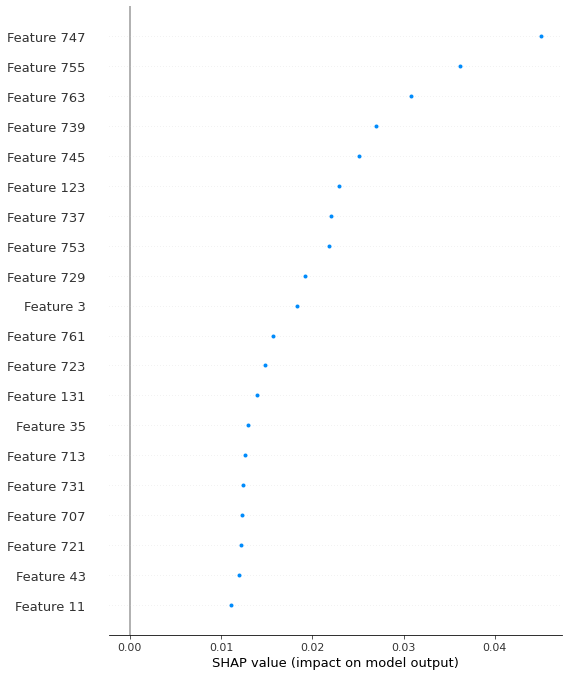

In [30]:
shap_redim = shap_values[:,:768,0]

shap.summary_plot(shap_values=shap_redim, features=shap_values.feature_names[:768])

# Applying SHAP to reduced wrapped model

### Prepare inputs (to explain, and for the masker) and global variables needed by the reduced wrapped model

In [16]:
# Get a subset of the train data
batch_x_train_sub = batch_x_train[:3,:,:]
batch_x_mark_train_sub = batch_x_mark_train[:3,:,:]
dec_inp_train_sub = dec_inp_train[:3,:,:]
batch_y_mark_train_sub = batch_y_mark_train[:3,:,:]

# Set common device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
exp.device = device
reduced_wrapped_model.to(device)

# Flatten X to be fed to the model
reduced_new_input = batch_x.flatten(start_dim=1).to(device)
reduced_new_input_train = batch_x_train_sub.flatten(start_dim=1).to(device)

# X converted to numpy for SHAP masker
reduced_new_input_train_np = reduced_new_input_train.cpu().detach().numpy()
reduced_new_input_np = reduced_new_input.cpu().detach().numpy()

# Define global variables for the wrapper to use
global_batch_x_mark = batch_x_mark.to(device)
global_batch_y_mark = batch_y_mark.to(device)

mask = shap.maskers.Independent(reduced_new_input_train_np)

explainer = shap.Explainer(reduced_wrapped_model,mask)

In [17]:
reduced_perm_shap_values = explainer(reduced_new_input_np, max_evals=2000)

Permutation explainer: 2it [05:19, 319.86s/it]                                                                         


In [17]:
# with open('Explanations/SHAP/shap_explanation_reduced_3b.pkl', 'wb') as file:
#     pickle.dump(reduced_perm_shap_values, file)
    
with open('Explanations/SHAP/shap_explanation_reduced_3b.pkl', 'rb') as file:
    reduced_perm_shap_values = pickle.load(file)

In [18]:
reduced_perm_shap_values.shape

(1, 768, 768)

In [19]:
# We are interested in seeing how the feature importance evolves as the model predicts further into the future,
# To achieve this, first we look at each output feature individually, and examine the effect 

current_batch=0
start_d = 0
end_d = reduced_wrapped_model.pred_len*exp.args.c_out

# SHAP values from desired inputs/outputs sorted by prediction horizon
print("SHAP values corresponding to desired inputs/outputs",shap_values[current_batch,start_d:end_d,::].shape)
print("Prediction horizon: ", pred_data.pred_len)
for i in range(pred_data.pred_len):
    if i<5 or i>90 or (i>45 and i <51):
        print("Time horizon {}: \t{}".format(i, shap_values[current_batch,i*8:(i+1)*8:,0].shape))
        
        # Chosen input feature from pred_len - one output feature
        print("",shap_values[current_batch,i*8:(i+1)*8:,0].values)      
        print("",reduced_perm_shap_values[current_batch,i*8:(i+1)*8:,0].values)      
        print()
        # All inputs from pred_len - one output feature
#         print("\t",shap_values[current_batch,i*8:(i+1)*8:,0].values)
#     print("SHAP values for feature {}: {}".format(pred_data.cols[1:][i], shap_values[current_batch,start_d:end_d,i::8].shape))


SHAP values corresponding to desired inputs/outputs (768, 768)
Prediction horizon:  96
Time horizon 0: 	(8,)
 [ 0.00216694  0.00444618  0.00279737  0.01832965  0.00155258  0.00334715
 -0.00590946 -0.00157155]
 [ 1.51875087e-03  6.06944816e-03  1.19550930e-04  1.30839449e-02
  5.85247763e-05  9.71722727e-04 -3.90678706e-03 -8.78126943e-04]

Time horizon 1: 	(8,)
 [ 0.00168456 -0.00135811  0.00090236  0.01112288 -0.00014157  0.00267171
 -0.00497017 -0.00389077]
 [ 0.00068097  0.00511002  0.00066977  0.00586959 -0.00019521  0.00010175
 -0.00637433 -0.00371617]

Time horizon 2: 	(8,)
 [ 1.68767665e-03 -5.80511987e-05  1.19578512e-03  2.55876407e-03
 -3.29631381e-04 -1.81976706e-04 -5.37029654e-03 -4.10065707e-03]
 [ 5.60212880e-04  7.58856675e-03  6.17339276e-04  8.27614916e-03
 -8.46643622e-05  3.18445576e-04 -1.79167790e-03 -4.92246759e-03]

Time horizon 3: 	(8,)
 [ 0.00130027  0.0033547   0.00091924  0.00418634 -0.0004557   0.00024526
 -0.00360258 -0.00655014]
 [ 1.24311571e-03  2.74963

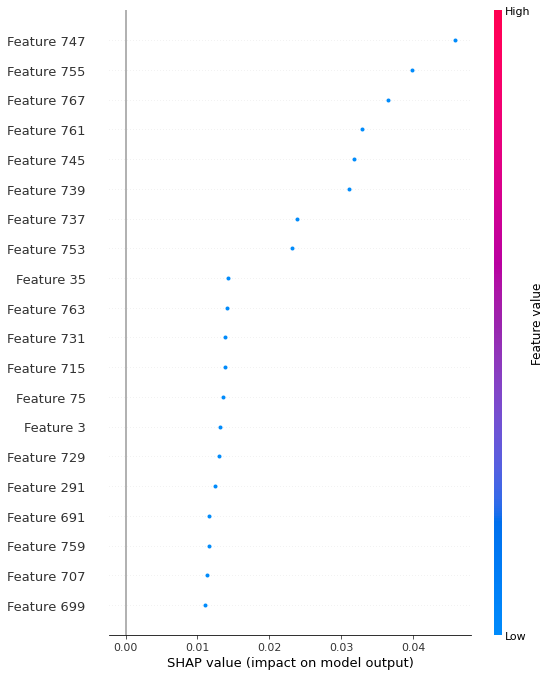

In [20]:

# shap.summary_plot(shap_values=reduced_shap_values, features=shap_values.feature_names[:768])
shap_redim = reduced_perm_shap_values[:,:,0]
%matplotlib inline 
shap.summary_plot(shap_redim, reduced_new_input_np)

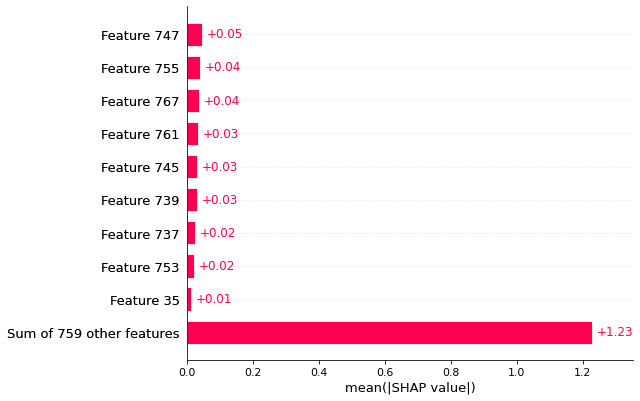

In [21]:
shap_redim = reduced_perm_shap_values[:,:,4]
%matplotlib inline 
shap.plots.bar(shap_redim)


# Reduced inputs and outputs model

## Permutation explainer

In [13]:
# Get a subset of the train data
batch_x_train_sub = batch_x_train[:4,:,:]
batch_x_mark_train_sub = batch_x_mark_train[:4,:,:]
dec_inp_train_sub = dec_inp_train[:4,:,:]
batch_y_mark_train_sub = batch_y_mark_train[:4,:,:]

# Flatten X to be fed to the model
reduced_new_input = batch_x.flatten(start_dim=1).to(device)
reduced_new_input_train = batch_x_train_sub.flatten(start_dim=1).to(device)

# X converted to numpy for SHAP masker
reduced_new_input_train_np = reduced_new_input_train.cpu().detach().numpy()
reduced_new_input_np = reduced_new_input.cpu().detach().numpy()

# Define global variables for the wrapper to use
global_batch_x_mark = batch_x_mark.to(device)
global_batch_y_mark = batch_y_mark.to(device)
pred_hor_explained = 0

reduced_io_wrapped_model = Reduced_io_transformer_wrapper(exp.args, global_batch_x_mark, 
                                                          global_batch_y_mark, device, 
                                                          pred_hor_explained).float()
reduced_io_wrapped_model.load_state_dict(model.state_dict())
reduced_io_wrapped_model.eval()

# Set common device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
exp.device = device
reduced_io_wrapped_model.to(device)

mask = shap.maskers.Independent(reduced_new_input_train_np)

explainer = shap.Explainer(reduced_io_wrapped_model,mask)

# reduced_io_perm_shap_values = explainer(reduced_new_input_np, max_evals=2000)

In [14]:
# with open('Explanations/SHAP/shap_explanation_reduced_io_3b.pkl', 'wb') as file:
#     pickle.dump(reduced_io_shap_values, file)
    
with open('Explanations/SHAP/shap_explanation_reduced_io_3b.pkl', 'rb') as file:
    reduced_io_perm_shap_values = pickle.load(file)


In [15]:
exp.args.c_out

8

In [56]:
# Create list to identify feature and position in the input sequence
feature_list = []
for i in range(exp.args.c_out*exp.args.seq_len):
    feature_list.append("Feature {}, seq pos {} ".format(pred_data.cols[1:][i%exp.args.c_out], int(i/exp.args.c_out)))

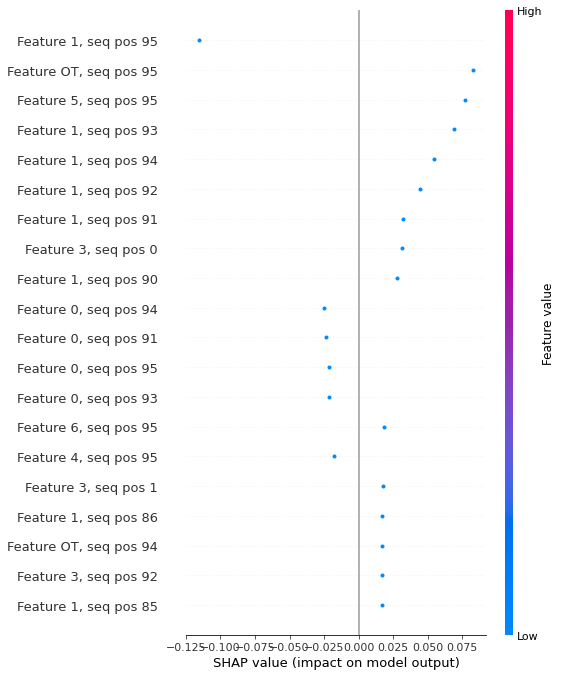

In [17]:
shap_redim = reduced_io_perm_shap_values[:,:,0]

shap.summary_plot(shap_values=shap_redim, feature_names=feature_list)

## DeepSHAP explainer (based on DeepLift)

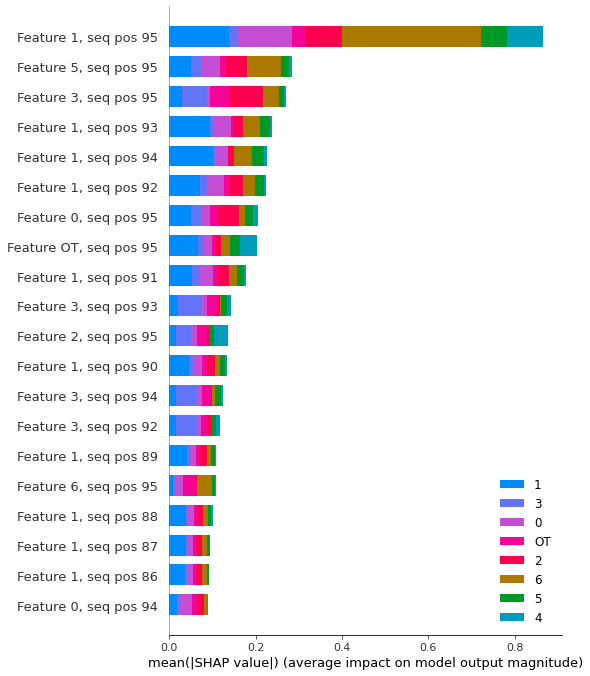

In [19]:
# Get a subset of the train data
batch_x_train_sub = batch_x_train[::50,:,:]

# Flatten X to be fed to the model
reduced_new_input = batch_x.flatten(start_dim=1).to(device)
reduced_new_input_train = batch_x_train_sub.flatten(start_dim=1).to(device)

# X converted to numpy for SHAP masker
reduced_new_input_train_np = reduced_new_input_train.cpu().detach().numpy()
reduced_new_input_np = reduced_new_input.cpu().detach().numpy()

# Define global variables for the wrapper to use
global_batch_x_mark = batch_x_mark.to(device)
global_batch_y_mark = batch_y_mark.to(device)
pred_hor_explained = 0

reduced_io_wrapped_model = Reduced_io_transformer_wrapper(exp.args, global_batch_x_mark, 
                                                          global_batch_y_mark, device, 
                                                          pred_hor_explained).float()
reduced_io_wrapped_model.load_state_dict(model.state_dict())
reduced_io_wrapped_model.eval()

# Set common device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
exp.device = device
reduced_io_wrapped_model.to(device)

torch.set_grad_enabled(True)

e = shap.DeepExplainer(reduced_io_wrapped_model, reduced_new_input_train)
reduced_io_deep_shap_values = e.shap_values(reduced_new_input)
shap.summary_plot(reduced_io_deep_shap_values, reduced_new_input, feature_names=feature_list, class_names=pred_data.cols[1:][:])

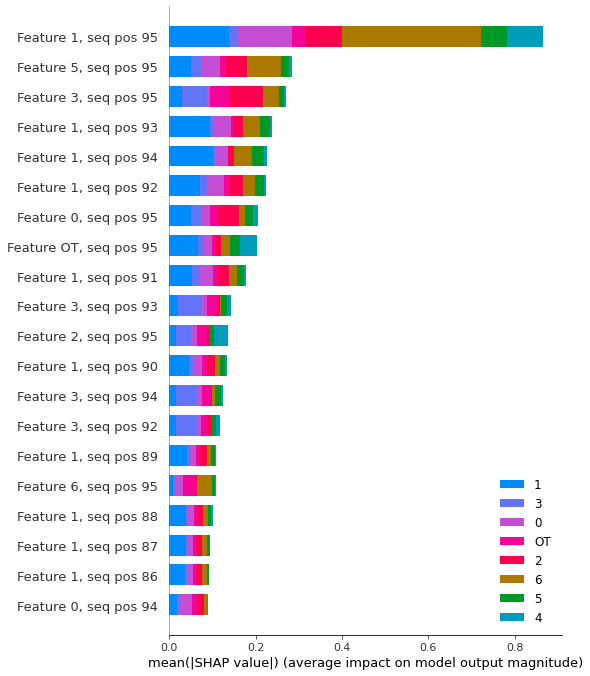

In [20]:
shap.summary_plot(reduced_io_deep_shap_values, reduced_new_input, feature_names=feature_list, class_names=pred_data.cols[1:][:])

### For first batch of training set

In [12]:
# Get a subset of the train data
batch_x_train_sub = batch_x_train[:32,:,:]
# Flatten X to be fed to the model
reduced_new_input = batch_x.flatten(start_dim=1).to(device)
reduced_new_input_train = batch_x_train_sub.flatten(start_dim=1).to(device)

# X converted to numpy for SHAP masker
reduced_new_input_train_np = reduced_new_input_train.cpu().detach().numpy()
reduced_new_input_np = reduced_new_input.cpu().detach().numpy()

# Define global variables for the wrapper to use
global_batch_x_mark = batch_x_mark.to(device)
global_batch_y_mark = batch_y_mark.to(device)
pred_hor_explained = 0

reduced_io_wrapped_model = Reduced_io_transformer_wrapper(exp.args, global_batch_x_mark, 
                                                          global_batch_y_mark, device, 
                                                          pred_hor_explained).float()
reduced_io_wrapped_model.load_state_dict(model.state_dict())
reduced_io_wrapped_model.eval()

# Set common device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
exp.device = device
reduced_io_wrapped_model.to(device)

torch.set_grad_enabled(True)

e = shap.DeepExplainer(reduced_io_wrapped_model, reduced_new_input_train)
# reduced_io_deep_shap_values = e.shap_values(reduced_new_input)

In [23]:
# with open('Explanations/SHAP/reduced_io_deep_shap_values_32b.pkl', 'wb') as file:
#     pickle.dump(reduced_io_deep_shap_values, file)

with open('Explanations/SHAP/reduced_io_deep_shap_values_32b.pkl', 'rb') as file:
    reduced_io_deep_shap_values = pickle.load(file)

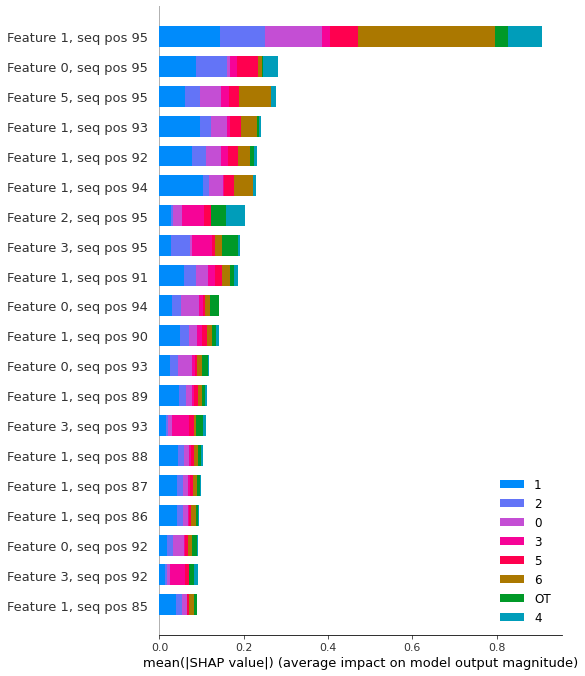

In [24]:
shap.summary_plot(reduced_io_deep_shap_values, reduced_new_input, feature_names=feature_list, class_names=pred_data.cols[1:][:])

### Deep SHAP for full time horizon

In [125]:
num_train_samples = 50

# Get a subset of the train data
batch_x_train_sub = batch_x_train[::round(batch_x_train.shape[0]/num_train_samples+0.5),:,:]

device = torch.device('cpu')

# Flatten X to be fed to the model
reduced_new_input = batch_x.flatten(start_dim=1).to(device)
reduced_new_input_train = batch_x_train_sub.flatten(start_dim=1).to(device)

# X converted to numpy for SHAP masker
reduced_new_input_train_np = reduced_new_input_train.cpu().detach().numpy()
reduced_new_input_np = reduced_new_input.cpu().detach().numpy()

# Define global variables for the wrapper to use
global_batch_x_mark = batch_x_mark.to(device)
global_batch_y_mark = batch_y_mark.to(device)
pred_hor_explained = 0

reduced_io_wrapped_model = Reduced_io_transformer_wrapper(exp.args, global_batch_x_mark, 
                                                          global_batch_y_mark, device, 
                                                          pred_hor_explained).float()
reduced_io_wrapped_model.load_state_dict(model.state_dict())
reduced_io_wrapped_model.eval()

# Set common device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
exp.device = device
reduced_io_wrapped_model.to(device)

torch.set_grad_enabled(True)

e = shap.DeepExplainer(reduced_io_wrapped_model, reduced_new_input_train)

# Each explained prediction horizon has to be analyzed individually to make it work with SHAP, so we store them in a list
reduced_deep_shap_values = []

# for pred_hor in range(reduced_io_wrapped_model.pred_len):
#     print("Analyzing time step ",pred_hor)
#     reduced_io_wrapped_model.set_pred_time_step(pred_hor)
#     reduced_deep_shap_values.append(e.shap_values(reduced_new_input))

In [126]:
# with open("Explanations/SHAP/shap_values_{}_in_{}_out_{}_{}_bg_{}.pkl".format(dataset_key, exp.args.seq_len, exp.args.pred_len, exp.args.model, num_train_samples), 'wb') as file:
#     pickle.dump(reduced_deep_shap_values, file)

with open("Explanations/SHAP/shap_values_{}_in_{}_out_{}_{}_bg_{}.pkl".format(dataset_key, exp.args.seq_len, exp.args.pred_len, exp.args.model, num_train_samples), 'rb') as file:
    reduced_deep_shap_values = pickle.load(file)

In [130]:
shap.summary_plot?

time step 48


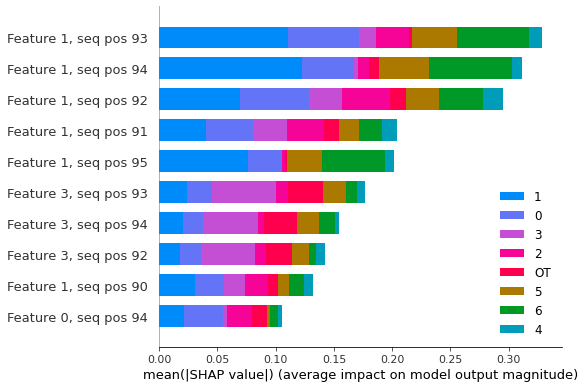

In [128]:
%matplotlib inline

for ind in [48]:
    print("time step {}".format(ind))
    shap.summary_plot(reduced_deep_shap_values[ind], reduced_new_input, feature_names=feature_list, class_names=pred_data.cols[1:][:], max_display=10)
#     shap.summary_plot(reduced_deep_shap_values[ind], reduced_new_input, feature_names=feature_list, class_names=pred_data.cols[1:][:], max_display=10)
    plt.show()

# print("asd")
# shap.summary_plot(reduced_deep_shap_values[0], reduced_new_input, feature_names=feature_list, class_names=pred_data.cols[1:][:], max_display=10)
# print("asdasd")
# shap.summary_plot(reduced_deep_shap_values[95], reduced_new_input, feature_names=feature_list, class_names=pred_data.cols[1:][:], max_display=10)

Input/output mode
accum_signals.shape (96, 96)


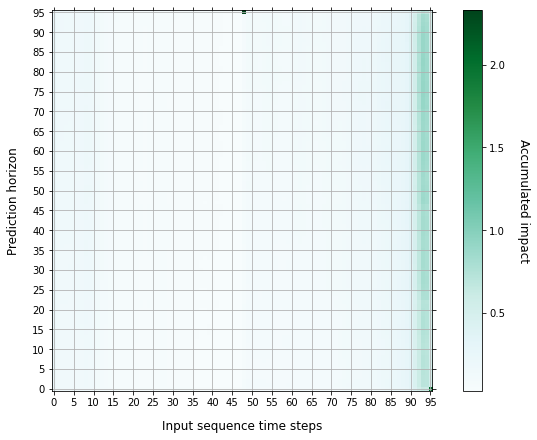

In [91]:
# %matplotlib inline 
# %matplotlib qt5

# matplotlib.use('Qt5Agg')
custom_cycler = (cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:8]) + 
                 cycler(linestyle=['dotted', 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5)), 
                                   (5, (10, 3)), (0, (5, 10)), (0, (5, 5)), (0, (5, 1))]))
plt.rc('axes', prop_cycle=custom_cycler)

pred_hor = 0
out_feat = 0
mode = 1
path = "figures"
fig_name = "\\shap_overview_{}_in_{}_out_{}_{}_bg_{}.pdf".format(dataset_key, exp.args.seq_len, exp.args.pred_len, exp.args.model, num_train_samples)
figsize = (11,7)


ChronoSHAP(reduced_deep_shap_values, exp.args.seq_len, 
                       exp.args.c_out, pred_data.cols[1:], mode, pred_hor, out_feat, grid=1, save=0, path=path+fig_name, figsize=figsize)




Output mode


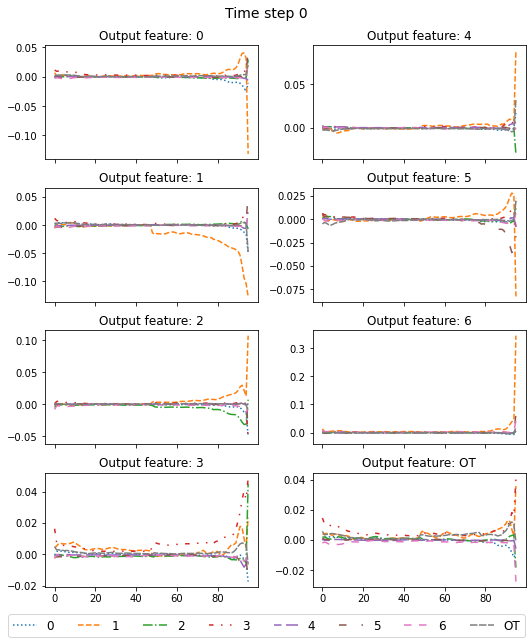

Output mode


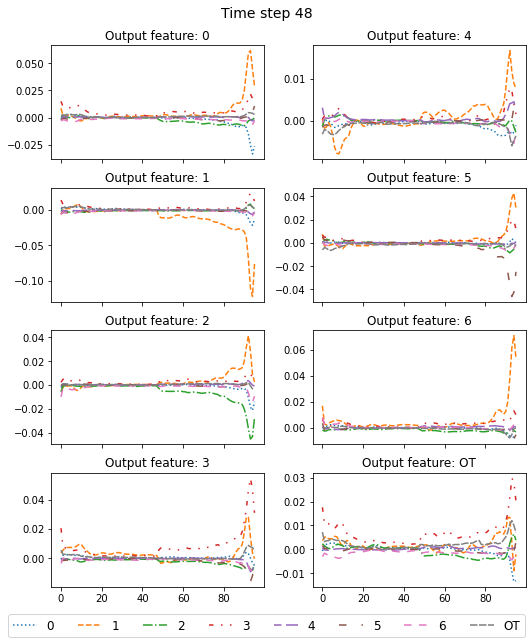

Output mode


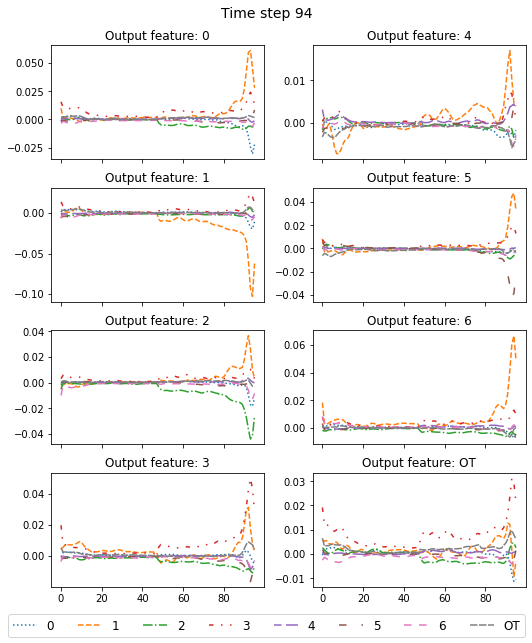

Output mode


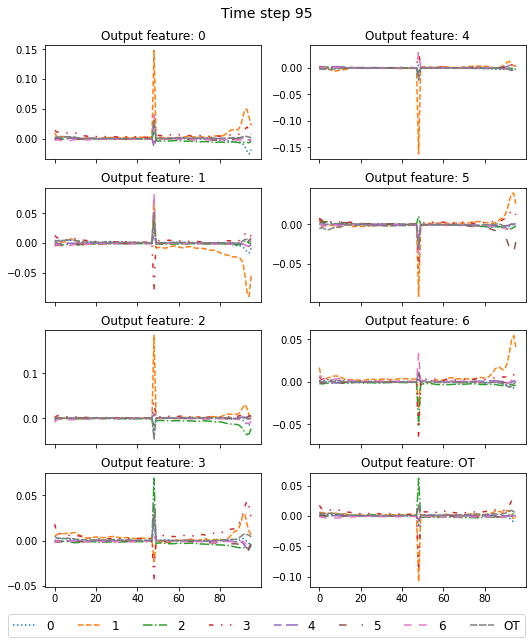

In [109]:
# %matplotlib qt5
%matplotlib inline

custom_cycler = (cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:8]) + 
                 cycler(linestyle=['dotted', 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5)), 
                                   (5, (10, 3)), (0, (5, 10)), (0, (5, 5)), (0, (5, 1))]))
plt.rc('axes', prop_cycle=custom_cycler)

out_feat = 0
mode = 0
path = "figures"
figsize=(7.5, 9)

for pred_hor in [0, 48, 94, 95]:
# for pred_hor in [0]:
    fig_name = "\\shap_pred_hor_{}_{}_in_{}_out_{}_{}_bg_{}.pdf".format(pred_hor, dataset_key, exp.args.seq_len, exp.args.pred_len, exp.args.model, num_train_samples)
    ChronoSHAP(reduced_deep_shap_values, exp.args.seq_len, 
                       exp.args.c_out, pred_data.cols[1:], mode, pred_hor, out_feat, custom_cycler, grid=0, save=0, path=path+fig_name, figsize=figsize)


### Remove outliers for better visualization

In [13]:
with open("Explanations/SHAP/shap_values_{}_in_{}_out_{}_{}_bg_{}.pkl".format(dataset_key, exp.args.seq_len, exp.args.pred_len, exp.args.model, num_train_samples), 'rb') as file:
    filtered_reduced_deep_shap_values = pickle.load(file)
    
anom = 95

print("Anomaly 1")
for i in range(len(filtered_reduced_deep_shap_values[anom])):
#     print(filtered_reduced_deep_shap_values[anom][i][:,48*exp.args.c_out:49*exp.args.c_out].shape)
#     print(np.mean([filtered_reduced_deep_shap_values[anom][i][:,47*exp.args.c_out:48*exp.args.c_out], 
#                    filtered_reduced_deep_shap_values[anom][i][:,49*exp.args.c_out:50*exp.args.c_out], 
#                    filtered_reduced_deep_shap_values[anom-1][i][:,48*exp.args.c_out:49*exp.args.c_out]], axis=0).shape)
    filtered_reduced_deep_shap_values[anom][i][:,48*exp.args.c_out:49*exp.args.c_out] = np.mean([filtered_reduced_deep_shap_values[anom][i][:,47*exp.args.c_out:48*exp.args.c_out], 
                                                                       filtered_reduced_deep_shap_values[anom][i][:,49*exp.args.c_out:50*exp.args.c_out], 
                                                                       filtered_reduced_deep_shap_values[anom-1][i][:,48*exp.args.c_out:49*exp.args.c_out]], 
                                                                      axis=0)

anom = 0
print("Anomaly 2")
for i in range(len(filtered_reduced_deep_shap_values[anom])):
#     print(filtered_reduced_deep_shap_values[anom][i].shape)
#     i[:,95*exp.args.c_out:96*exp.args.c_out] = np.mean([i[:,95*exp.args.c_out:96*exp.args.c_out],i[:,95*exp.args.c_out:96*exp.args.c_out]], axis=0)
    filtered_reduced_deep_shap_values[anom][i][:,95*exp.args.c_out:96*exp.args.c_out] = np.mean([filtered_reduced_deep_shap_values[anom][i][:,94*exp.args.c_out:95*exp.args.c_out], 
                                                                       filtered_reduced_deep_shap_values[anom+1][i][:,95*exp.args.c_out:96*exp.args.c_out]], 
                                                                      axis=0)

Anomaly 1
Anomaly 2


Input/output mode
accum_signals.shape (96, 96)


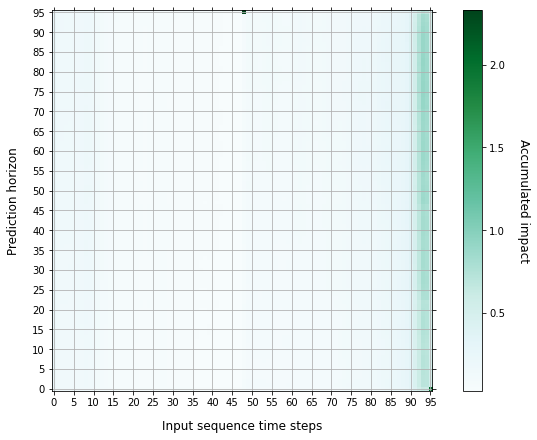

Input/output mode
accum_signals.shape (96, 96)


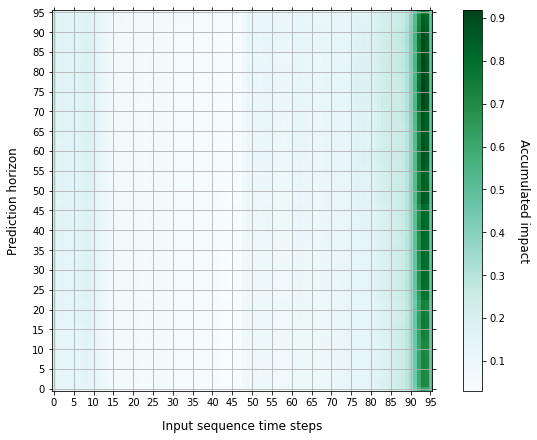

In [14]:
# %matplotlib inline 
# %matplotlib qt5

# matplotlib.use('Qt5Agg')
custom_cycler = (cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:8]) + 
                 cycler(linestyle=['dotted', 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5)), 
                                   (5, (10, 3)), (0, (5, 10)), (0, (5, 5)), (0, (5, 1))]))
plt.rc('axes', prop_cycle=custom_cycler)

pred_hor = 0
out_feat = 0
mode = 1
path = "figures"
fig_name = "\\shap_overview_{}_in_{}_out_{}_{}_bg_{}.pdf".format(dataset_key, exp.args.seq_len, exp.args.pred_len, exp.args.model, num_train_samples)
figsize = (11,7)

ChronoSHAP(reduced_deep_shap_values, exp.args.seq_len, 
                       exp.args.c_out, pred_data.cols[1:], mode, pred_hor, out_feat, grid=1, save=0, path=path+fig_name, figsize=figsize)


path = "figures"
fig_name = "\\shap_overview_{}_in_{}_out_{}_{}_bg_{}_no_outliers.pdf".format(dataset_key, exp.args.seq_len, exp.args.pred_len, exp.args.model, num_train_samples)
figsize = (11,7)

ChronoSHAP(filtered_reduced_deep_shap_values, exp.args.seq_len, 
                       exp.args.c_out, pred_data.cols[1:], mode, pred_hor, out_feat, grid=1, save=0, path=path+fig_name, figsize=figsize)



## Kernel SHAP explainer 

In [29]:
from torch.autograd import Variable

# Get a subset of the train data
batch_x_train_sub = batch_x_train[:16,:,:]

# Flatten X to be fed to the model
reduced_new_input = batch_x.flatten(start_dim=1).to(device)
reduced_new_input_train = batch_x_train_sub.flatten(start_dim=1).to(device)

# X converted to numpy for SHAP masker
reduced_new_input_train_np = reduced_new_input_train.cpu().detach().numpy()
reduced_new_input_np = reduced_new_input.cpu().detach().numpy()

# Define global variables for the wrapper to use
global_batch_x_mark = batch_x_mark.to(device)
global_batch_y_mark = batch_y_mark.to(device)
pred_hor_explained = 0

device = torch.device('cpu')
reduced_io_wrapped_model = Reduced_io_transformer_wrapper(exp.args, global_batch_x_mark, 
                                                          global_batch_y_mark, device, 
                                                          pred_hor_explained).float()
reduced_io_wrapped_model.load_state_dict(model.state_dict())
reduced_io_wrapped_model.eval()

# Set common device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
exp.device = device
reduced_io_wrapped_model.to(device)

# Wrap the model to convert outputs to numpy
f = lambda x: reduced_io_wrapped_model( Variable( torch.from_numpy(x) ) ).detach().numpy()

torch.set_grad_enabled(False)

explainer = shap.KernelExplainer(f, reduced_new_input_train_np)
reduced_io_kernel_shap_values = explainer.shap_values(reduced_new_input_np)


  0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
# with open('Explanations/SHAP/reduced_io_kernel_shap_values_16b.pkl', 'wb') as file:
#     pickle.dump(reduced_io_kernel_shap_values, file)

with open('Explanations/SHAP/reduced_io_kernel_shap_values_16b.pkl', 'rb') as file:
    reduced_io_kernel_shap_values = pickle.load(file)

In [31]:
feature_list

['Feature 0, seq pos 0 ',
 'Feature 1, seq pos 0 ',
 'Feature 2, seq pos 0 ',
 'Feature 3, seq pos 0 ',
 'Feature 4, seq pos 0 ',
 'Feature 5, seq pos 0 ',
 'Feature 6, seq pos 0 ',
 'Feature OT, seq pos 0 ',
 'Feature 0, seq pos 1 ',
 'Feature 1, seq pos 1 ',
 'Feature 2, seq pos 1 ',
 'Feature 3, seq pos 1 ',
 'Feature 4, seq pos 1 ',
 'Feature 5, seq pos 1 ',
 'Feature 6, seq pos 1 ',
 'Feature OT, seq pos 1 ',
 'Feature 0, seq pos 2 ',
 'Feature 1, seq pos 2 ',
 'Feature 2, seq pos 2 ',
 'Feature 3, seq pos 2 ',
 'Feature 4, seq pos 2 ',
 'Feature 5, seq pos 2 ',
 'Feature 6, seq pos 2 ',
 'Feature OT, seq pos 2 ',
 'Feature 0, seq pos 3 ',
 'Feature 1, seq pos 3 ',
 'Feature 2, seq pos 3 ',
 'Feature 3, seq pos 3 ',
 'Feature 4, seq pos 3 ',
 'Feature 5, seq pos 3 ',
 'Feature 6, seq pos 3 ',
 'Feature OT, seq pos 3 ',
 'Feature 0, seq pos 4 ',
 'Feature 1, seq pos 4 ',
 'Feature 2, seq pos 4 ',
 'Feature 3, seq pos 4 ',
 'Feature 4, seq pos 4 ',
 'Feature 5, seq pos 4 ',
 'Featur

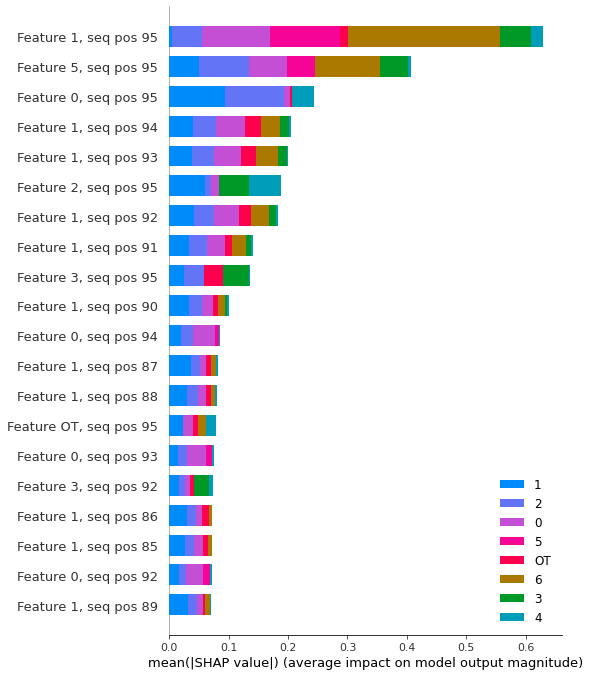

In [32]:
shap.summary_plot(reduced_io_kernel_shap_values, reduced_new_input, feature_names=feature_list, class_names=pred_data.cols[1:][:], max_display=20)

### Kernel SHAP explainer for full time horizon

In [33]:
# Get a subset of the train data
batch_x_train_sub = batch_x_train[:4,:,:]

# Set common device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
exp.device = device
reduced_io_wrapped_model.to(device)

# Flatten X to be fed to the model
reduced_new_input = batch_x.flatten(start_dim=1).to(device)
reduced_new_input_train = batch_x_train_sub.flatten(start_dim=1).to(device)

# X converted to numpy for SHAP masker
reduced_new_input_train_np = reduced_new_input_train.cpu().detach().numpy()
reduced_new_input_np = reduced_new_input.cpu().detach().numpy()

# Define global variables for the wrapper to use
global_batch_x_mark = batch_x_mark.to(device)
global_batch_y_mark = batch_y_mark.to(device)

device = torch.device('cpu')
reduced_io_wrapped_model = Reduced_io_transformer_wrapper(exp.args, global_batch_x_mark, 
                                                          global_batch_y_mark, device, 
                                                          pred_hor_explained).float()
reduced_io_wrapped_model.load_state_dict(model.state_dict())
reduced_io_wrapped_model.eval()

# Set common device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
exp.device = device
reduced_io_wrapped_model.to(device)

# Wrap the model to convert outputs to numpy
f = lambda x: reduced_io_wrapped_model( Variable( torch.from_numpy(x) ) ).detach().numpy()

torch.set_grad_enabled(False)

explainer = shap.KernelExplainer(f, reduced_new_input_train_np)

# Each explained prediction horizon has to be analyzed individually to make it work with SHAP, so we store them in a list
reduced_kernel_shap_values = []

# for pred_hor in range(reduced_io_wrapped_model.pred_len):
#     reduced_io_wrapped_model.set_pred_time_step(pred_hor)
#     reduced_kernel_shap_values.append(explainer.shap_values(reduced_new_input_np))




In [34]:
# with open('Explanations/SHAP/reduced_kernel_shap_values_4b.pkl', 'wb') as file:
#     pickle.dump(reduced_kernel_shap_values, file)

with open('Explanations/SHAP/reduced_kernel_shap_values_4b.pkl', 'rb') as file:
    reduced_kernel_shap_values = pickle.load(file)

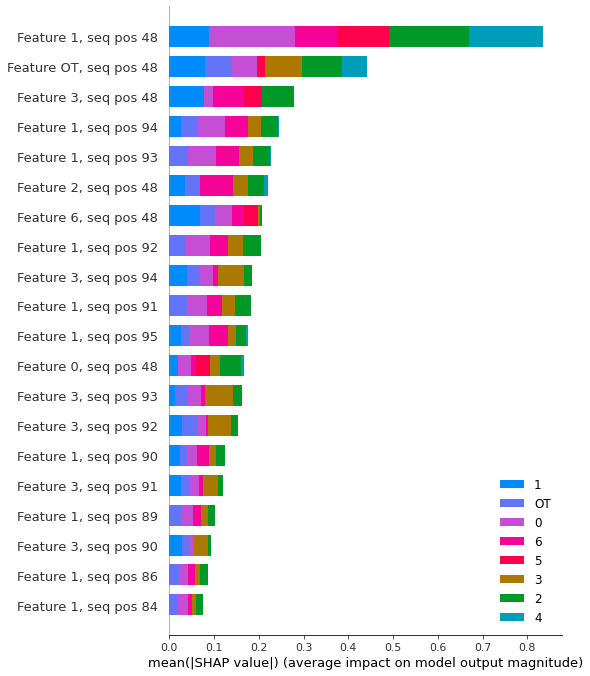

In [35]:
shap.summary_plot(reduced_kernel_shap_values[95], reduced_new_input, feature_names=feature_list, class_names=pred_data.cols[1:][:], max_display=20)

### Feature attribution scores evolution over time

We look at the evolution of the attribution scores
considering all time steps from input and output sequences. To
be able to display the overall evolution of the input features’
impact, we look separately into specific output features of the
model, gaining more general information about how the impact
of the features from different time steps of the input varies de-
pending on the prediction horizon.

In [18]:
feature_list

['Feature 0, seq pos 0 ',
 'Feature 1, seq pos 0 ',
 'Feature 2, seq pos 0 ',
 'Feature 3, seq pos 0 ',
 'Feature 4, seq pos 0 ',
 'Feature 5, seq pos 0 ',
 'Feature 6, seq pos 0 ',
 'Feature OT, seq pos 0 ',
 'Feature 0, seq pos 1 ',
 'Feature 1, seq pos 1 ',
 'Feature 2, seq pos 1 ',
 'Feature 3, seq pos 1 ',
 'Feature 4, seq pos 1 ',
 'Feature 5, seq pos 1 ',
 'Feature 6, seq pos 1 ',
 'Feature OT, seq pos 1 ',
 'Feature 0, seq pos 2 ',
 'Feature 1, seq pos 2 ',
 'Feature 2, seq pos 2 ',
 'Feature 3, seq pos 2 ',
 'Feature 4, seq pos 2 ',
 'Feature 5, seq pos 2 ',
 'Feature 6, seq pos 2 ',
 'Feature OT, seq pos 2 ',
 'Feature 0, seq pos 3 ',
 'Feature 1, seq pos 3 ',
 'Feature 2, seq pos 3 ',
 'Feature 3, seq pos 3 ',
 'Feature 4, seq pos 3 ',
 'Feature 5, seq pos 3 ',
 'Feature 6, seq pos 3 ',
 'Feature OT, seq pos 3 ',
 'Feature 0, seq pos 4 ',
 'Feature 1, seq pos 4 ',
 'Feature 2, seq pos 4 ',
 'Feature 3, seq pos 4 ',
 'Feature 4, seq pos 4 ',
 'Feature 5, seq pos 4 ',
 'Featur

In [17]:
# for pred_hor in range(reduced_io_wrapped_model.pred_len):
#     pred_hor_explained = pred_hor
#     reduced_deep_shap_values.append(e.shap_values(reduced_new_input))

print("reduced_new_input\t\t\t", reduced_new_input.shape)
print("reduced_io_wrapped_model\t\t", reduced_io_wrapped_model(reduced_new_input).shape)

print("reduced_deep_shap_values\t\t", len(reduced_deep_shap_values))
print("reduced_deep_shap_values[0]\t\t", len(reduced_deep_shap_values[0]))
print("reduced_deep_shap_values[0][0]\t\t", len(reduced_deep_shap_values[0][0]))
print("reduced_deep_shap_values[0][0].shape\t", (reduced_deep_shap_values[0][0]).shape)

reduced_new_input			 torch.Size([1, 768])
reduced_io_wrapped_model		 torch.Size([1, 8])
reduced_deep_shap_values		 96
reduced_deep_shap_values[0]		 8
reduced_deep_shap_values[0][0]		 1
reduced_deep_shap_values[0][0].shape	 (1, 768)


In [19]:
# dim 0: prediction horizon index
# dim 1: output features index
# dim 2, 3: shap_values for each element of the input sequence (seq_len) for all input features (c_out)

aux = np.asarray(reduced_deep_shap_values).squeeze()
print(aux.shape)

aux = aux.reshape((aux.shape[0], aux.shape[1], exp.args.seq_len, exp.args.c_out))
print(aux.shape)

(96, 8, 768)
(96, 8, 96, 8)


In [20]:
pred_hor = 0
out_feat = 0
mode = 0

for i in range(len(reduced_deep_shap_values[pred_hor])):
    print(i, i%4, 4%(i+1))

0 0 0
1 1 0
2 2 1
3 3 0
4 0 4
5 1 4
6 2 4
7 3 4


In [14]:
# print(plt.rcParams['axes.prop_cycle'].by_key()['color'][:8])
custom_cycler = (cycler(linestyle=['-', '--', '-.', ':', '.', 'o', 'x', '>']) +
                 cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:8]))
custom_cycler

'#1f77b4','-'
'#ff7f0e','--'
'#2ca02c','-.'
'#d62728',':'
'#9467bd','.'
'#8c564b','o'
'#e377c2','x'
'#7f7f7f','>'


In [15]:
%matplotlib -l

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [52]:
signals = np.asarray(reduced_deep_shap_values).squeeze()
signals = signals.reshape((signals.shape[0], signals.shape[1], exp.args.seq_len, exp.args.c_out))
# accum_signals = np.sum(np.abs(signals), axis=(1,3))
signals.shape

(96, 8, 96, 8)

In [53]:
display(signals[95,:,48,:])

print(abs(signals[95,:,48,:]).sum())

display(signals[0,:,95,:])

print(abs(signals[0,:,95,:]).sum())

array([[ 0.04507526,  0.14442083,  0.00979451,  0.00088253, -0.0074962 ,
         0.00559304,  0.04080253,  0.02873616],
       [ 0.02942887,  0.06468685,  0.04589158, -0.06789429,  0.00780322,
         0.0127416 ,  0.07167013,  0.03655715],
       [-0.04188167,  0.17932643, -0.01916728,  0.04804591,  0.01415866,
         0.01672295,  0.00329178, -0.0266626 ],
       [ 0.03052089, -0.0283371 ,  0.07036985, -0.03414486,  0.01661177,
        -0.00485685,  0.00694031,  0.0328868 ],
       [ 0.00086139, -0.1541931 , -0.00697759,  0.03068271, -0.00468906,
        -0.01079051,  0.0264595 , -0.01656283],
       [-0.02856701, -0.0966928 ,  0.01340491, -0.04346807, -0.01183507,
        -0.01534444, -0.03065624, -0.01665039],
       [ 0.01742916, -0.03055173, -0.07113073, -0.05410451,  0.01259989,
         0.00799776,  0.02752499,  0.00589235],
       [-0.0204047 , -0.10149045,  0.06569853, -0.06630188, -0.00370351,
         0.00510812,  0.01430795,  0.01628757]])

2.221769919153303


array([[ 6.96173962e-03, -1.35716781e-01,  2.24152710e-02,
         5.24511375e-03, -6.05948921e-03,  5.17115220e-02,
         2.02014819e-02,  1.18334815e-02],
       [-8.56839269e-02, -1.44451946e-01, -2.71592084e-02,
         2.74969973e-02,  1.42333861e-02,  6.03123866e-02,
         1.24435313e-02, -1.69769060e-02],
       [-7.53075853e-02,  1.05348833e-01,  4.61668149e-03,
        -4.50321585e-02,  2.16949638e-03, -3.50590497e-02,
         1.11199217e-03, -6.88450132e-03],
       [-1.54684838e-02,  1.85781624e-02,  5.24183065e-02,
         4.78662550e-02, -6.37825951e-03, -1.87385175e-02,
         3.82764684e-03,  1.72213255e-03],
       [ 3.48958336e-02,  8.28825012e-02, -4.49415557e-02,
         5.11447294e-03,  1.08876806e-02,  1.27657019e-02,
         5.10548847e-03,  1.93389021e-02],
       [ 5.01535274e-02, -6.74202368e-02,  1.57935210e-02,
        -5.30853588e-03, -8.56615510e-03, -2.23341417e-02,
         3.06622637e-03,  1.59088708e-02],
       [-1.07317828e-02,  3.249511

2.103874808875844


### Comparing Deep and Kernel Shapley values

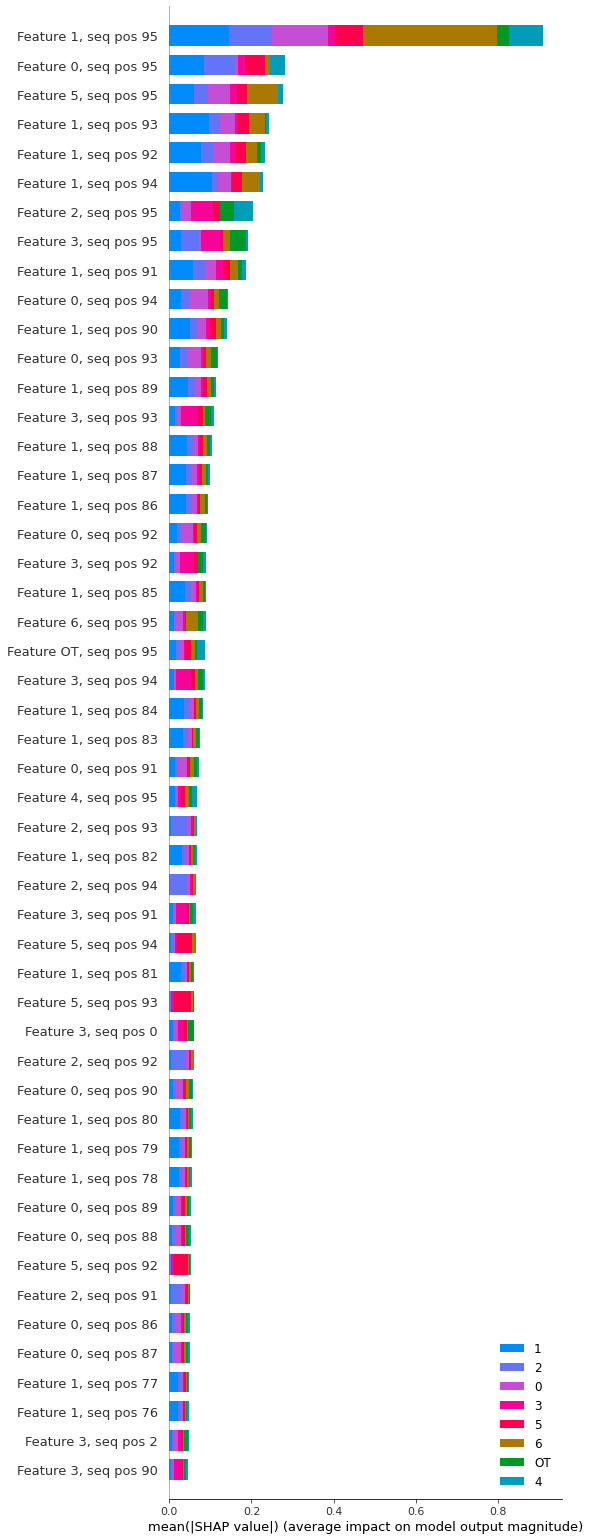

In [55]:
shap.summary_plot(reduced_deep_shap_values[0], reduced_new_input, feature_names=feature_list, class_names=pred_data.cols[1:][:], max_display=50)

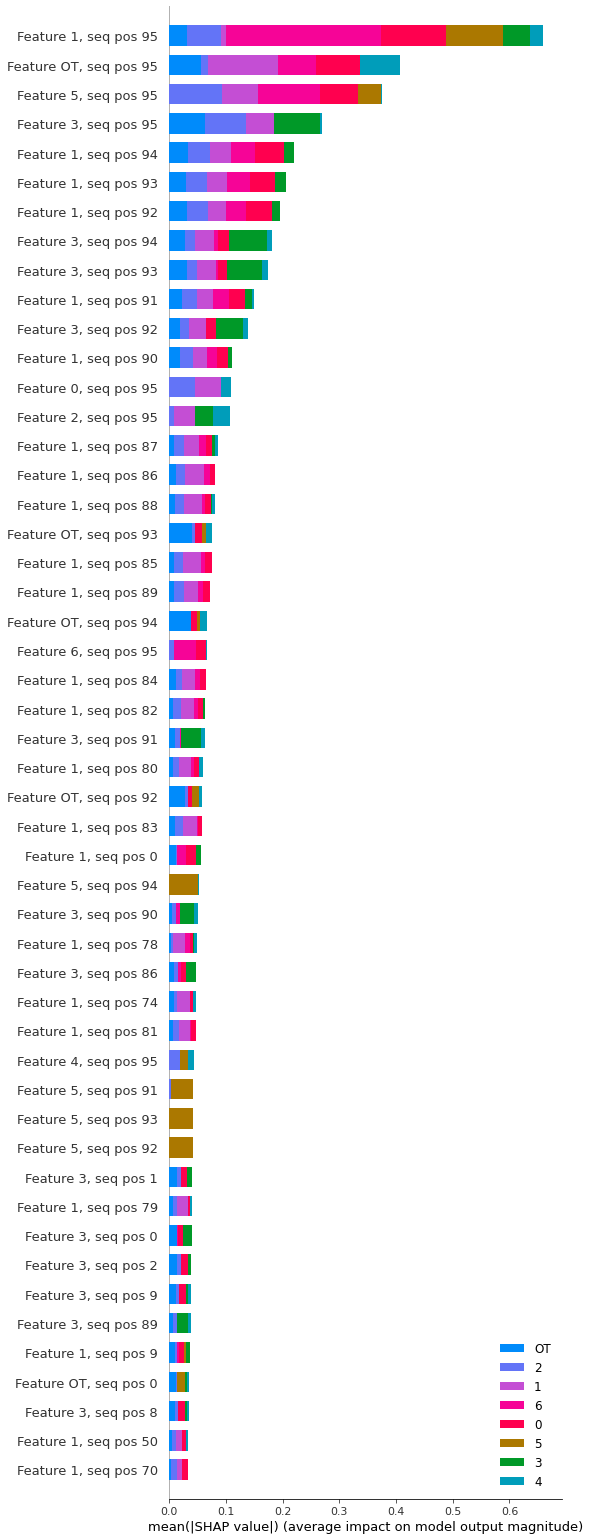

In [56]:
shap.summary_plot(reduced_kernel_shap_values[0], reduced_new_input, feature_names=feature_list, class_names=pred_data.cols[1:][:], max_display=50)

# Comparison between Deep and Kernel feature attribution scores 

In [57]:
def smape(actual, predicted) -> float:
    # Convert actual and predicted to numpy 
    if not all([isinstance(actual, np.ndarray),  
                isinstance(predicted, np.ndarray)]): 
        actual, predicted = np.array(actual), 
        np.array(predicted) 
  
    return np.mean(np.abs(predicted - actual) / 
                   ((np.abs(predicted) + np.abs(actual))/2)
                  )*100

smape(reduced_io_deep_shap_values[0], reduced_io_kernel_shap_values[0])

174.73420070742753

In [58]:
# Errors / distances between feature attributions when computed for the first step of pred. horizon with max background data

mape1_list = []
smape1_list = []
mse1_list = []
rmse1_list = []

for i in range(len(reduced_io_kernel_shap_values)):
    for j in range(len(reduced_io_kernel_shap_values[0])):
        mape1_list.append(mean_absolute_percentage_error(reduced_io_deep_shap_values[i][j],reduced_io_kernel_shap_values[i][j]))
        smape1_list.append(smape(reduced_io_deep_shap_values[i][j],reduced_io_kernel_shap_values[i][j]))
        mse1_list.append(mean_squared_error(reduced_io_deep_shap_values[i][j],reduced_io_kernel_shap_values[i][j]))
        rmse1_list.append(np.sqrt(mean_squared_error(reduced_io_deep_shap_values[i][j],reduced_io_kernel_shap_values[i][j])))

print("MAPE =\t", np.mean(mape1_list))
print("SMAPE =\t", np.mean(smape1_list))
print("MSE =\t", np.mean(mse1_list))
print("RMSE =\t", np.mean(rmse1_list))

MAPE =	 2.5932777729940355
SMAPE =	 175.48091571068903
MSE =	 1.4609799353468122e-05
RMSE =	 0.0035982984491613147


In [59]:
# Errors / distances between feature attributions when computed for the whole pred. horizon with reduced background data

mse_list = []
rmse_list = []
mape_list = []
smape_list = []
# remove [0] from both reduced_deep_shap_values to compute these measurements for the whole SHAP values instead of time step 0
for i in range(len(reduced_deep_shap_values[0])):
    for j in range(len(reduced_deep_shap_values[0][0])):
        mape_list.append(mean_absolute_percentage_error(reduced_deep_shap_values[i][j],reduced_kernel_shap_values[i][j]))
        smape_list.append(smape(reduced_deep_shap_values[i][j],reduced_kernel_shap_values[i][j]))
        mse_list.append(mean_squared_error(reduced_deep_shap_values[i][j],reduced_kernel_shap_values[i][j]))
        rmse_list.append(np.sqrt(mean_squared_error(reduced_deep_shap_values[i][j],reduced_kernel_shap_values[i][j])))

print("MAPE =\t", np.mean(mape_list))
print("SMAPE =\t", np.mean(smape_list))
print("MSE =\t", np.mean(mse_list))
print("RMSE =\t", np.mean(rmse_list))

MAPE =	 5.0948809451186765
SMAPE =	 184.3850226781579
MSE =	 2.135387038516548e-05
RMSE =	 0.004617516482605543


In [60]:
np.abs(np.mean(smape1_list)-np.mean(smape_list))/((np.mean(smape1_list)+np.mean(smape_list))/2)*100

4.948568907262173

In [61]:
np.abs(np.mean(rmse1_list)-np.mean(rmse_list))/((np.mean(rmse1_list)+np.mean(rmse_list))/2)*100

24.811124444962136